In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM4.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

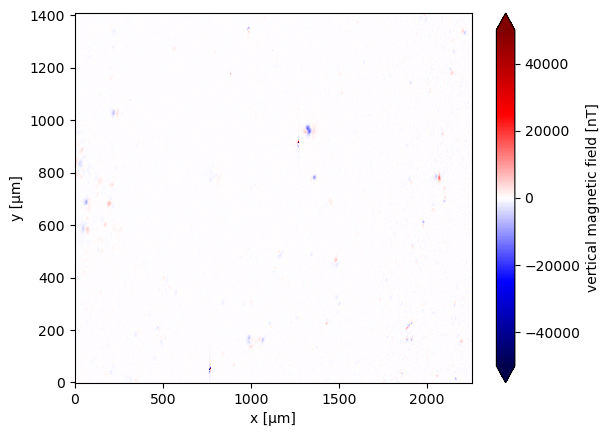

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 35.17 21.4 8.557 9.319 ... 50.4 60.44 49.07

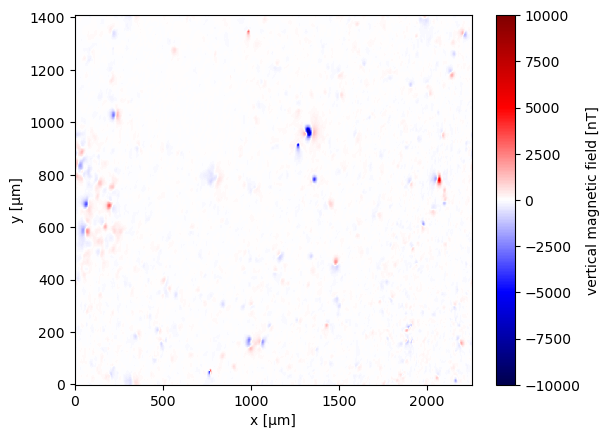

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 35.17 21.4 8.557 9.319 ... 50.4 60.44 49.07
    tga      (y, x) float64 5MB 7.034 6.126 4.062 6.029 ... 11.23 13.37 7.375
    x_deriv  (y, x) float64 5MB -5.858 -5.662 -2.571 ... 7.776 -0.2839 -4.839
    y_deriv  (y, x) float64 5MB -0.1312 1.164 0.9491 ... 0.927 0.776 0.06478
    z_deriv  (y, x) float64 5MB -3.891 -2.029 2.998 ... -8.054 -13.35 -5.565

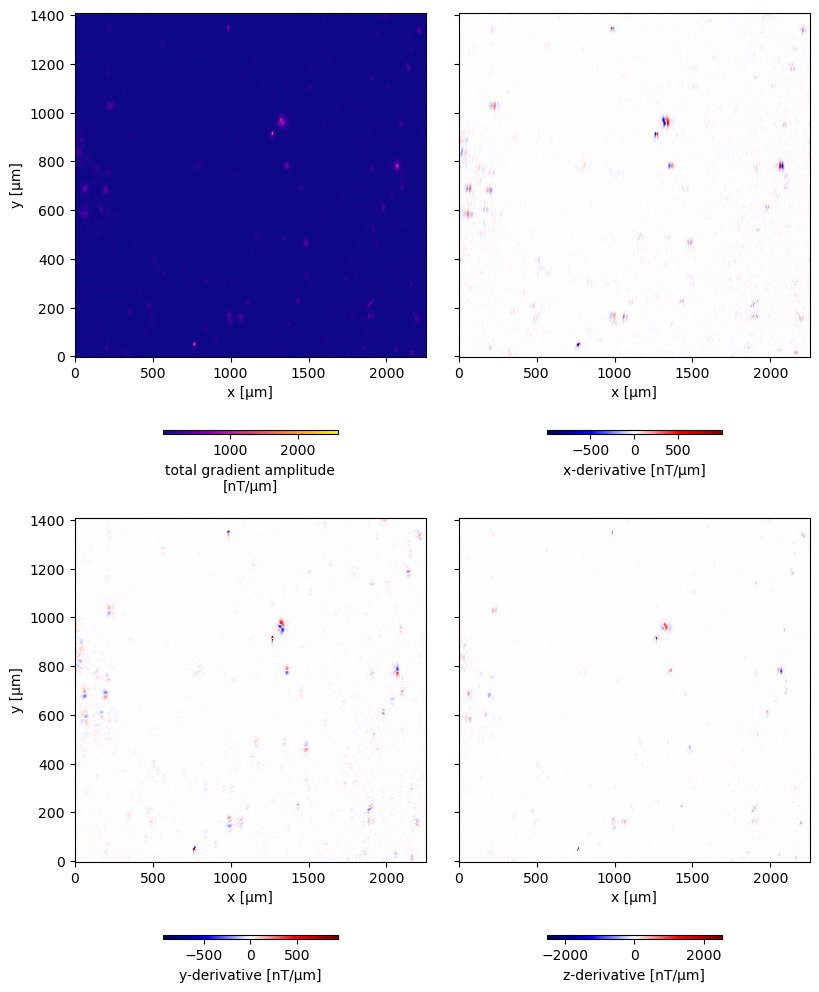

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

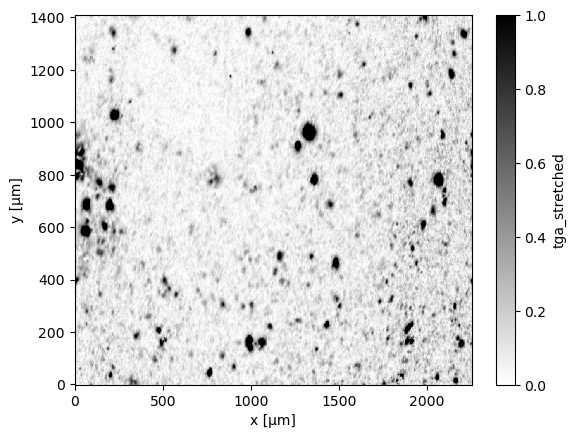

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

317 potential sources detected within 1.8208 seconds


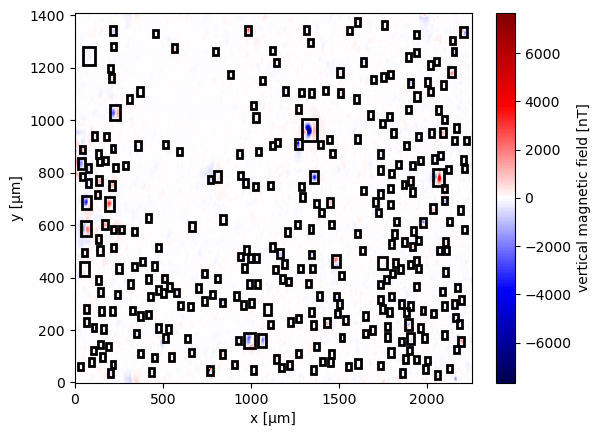

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

317 euler positions and dipole moments estimated within 1.7888 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 94.4146 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z          bz    z_deriv
0  749.65  30.55  10.0 -115.618022 -10.027975
1  752.00  30.55  10.0 -183.634247  -8.669418
2  754.35  30.55  10.0 -268.659719  -6.507989
3  756.70  30.55  10.0 -374.627864   7.033475
4  759.05  30.55  10.0 -488.370597  25.916755

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

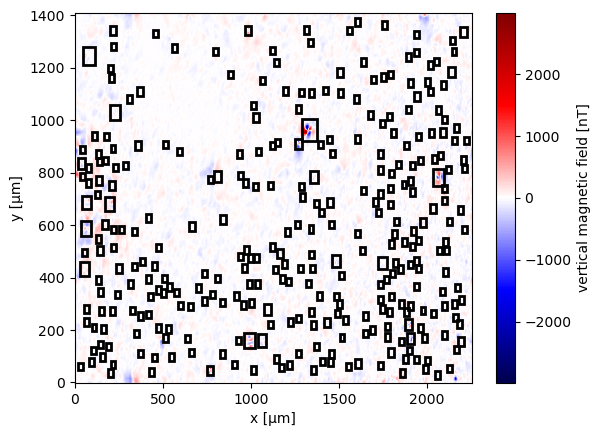

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

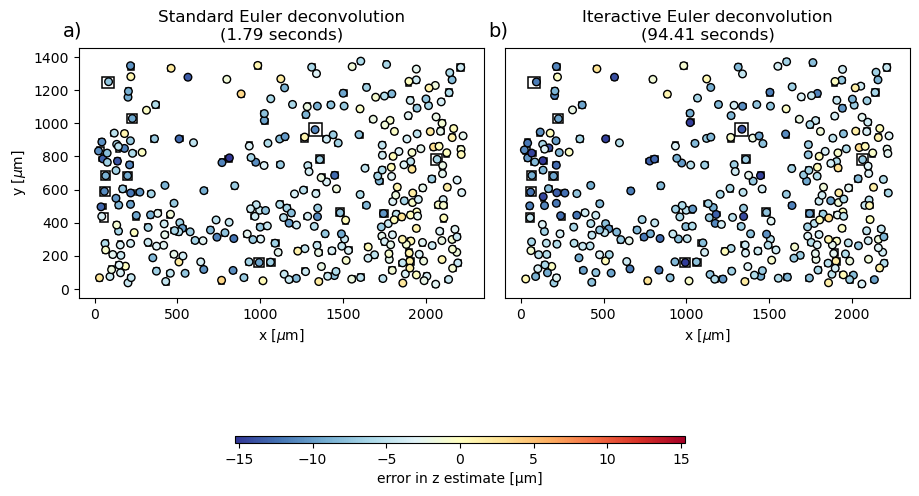

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

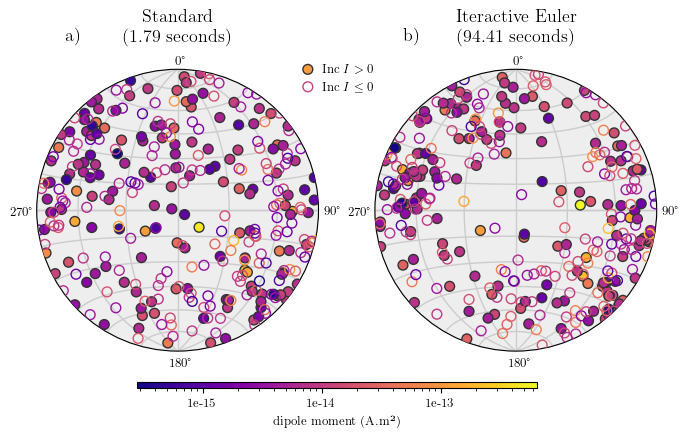

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

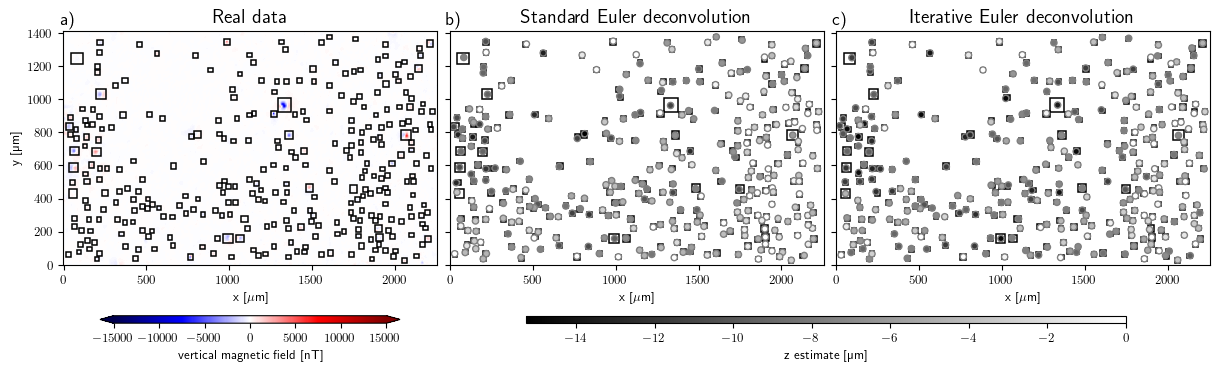

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


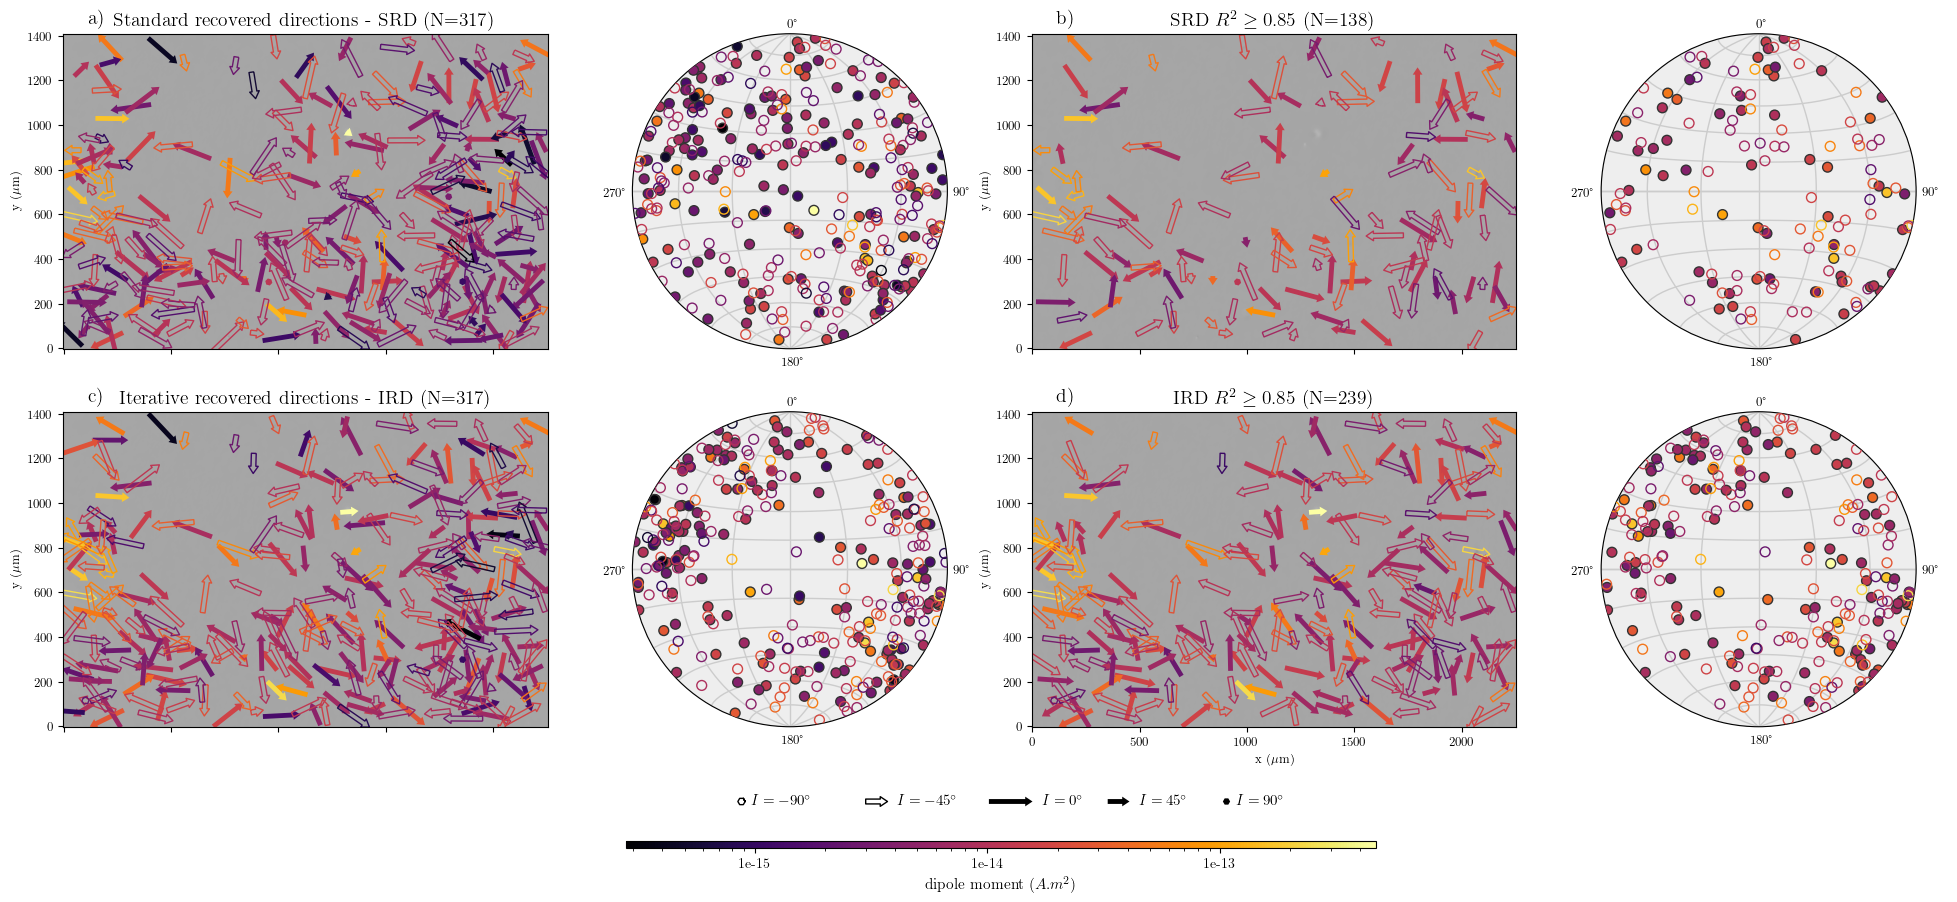

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

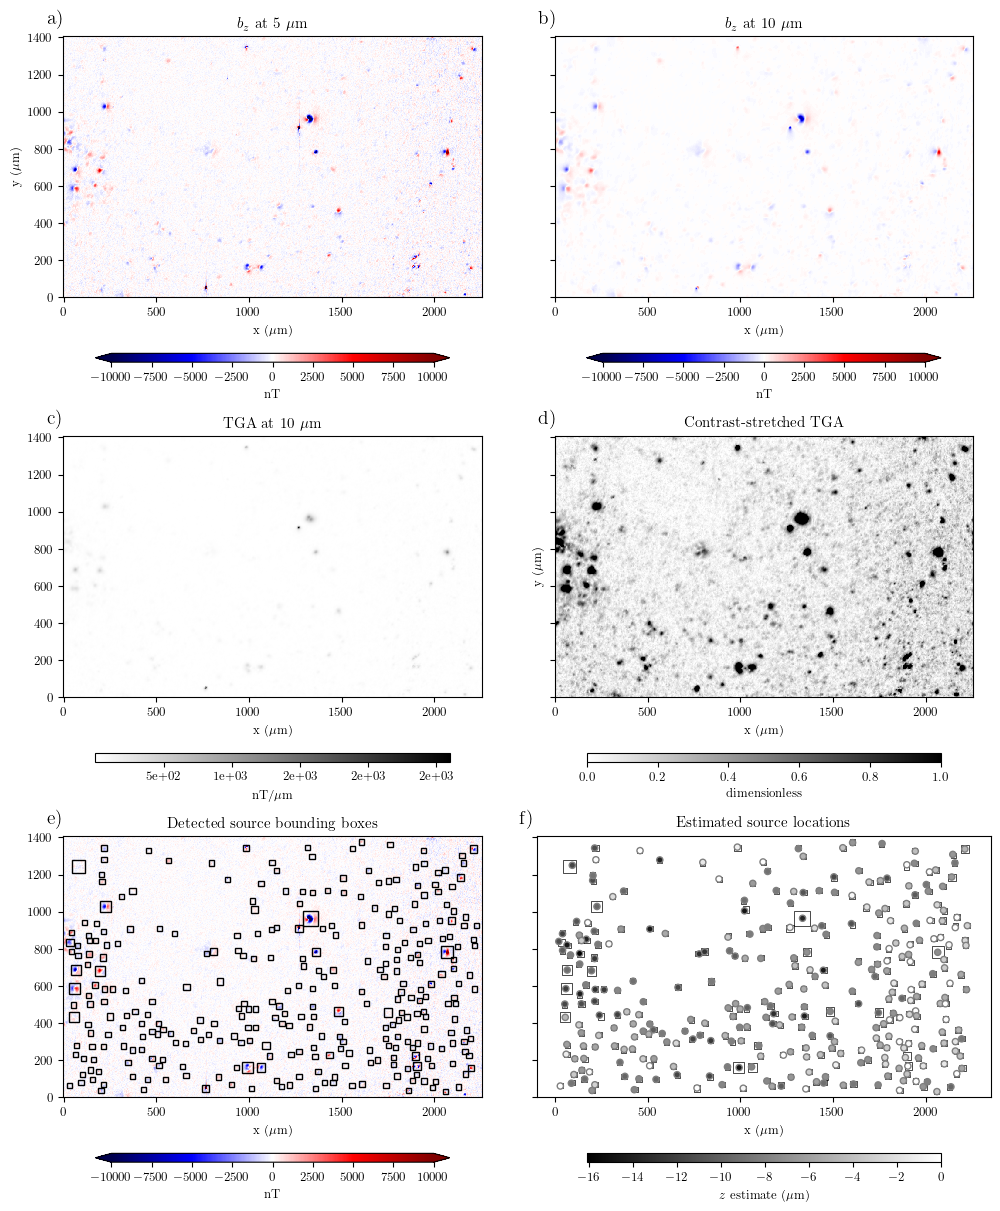

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 34.8 20.97 8.074 8.797 ... 49.98 60.08 48.73
    tga      (y, x) float64 5MB 7.062 6.14 4.077 6.032 ... 11.27 13.39 7.375
    x_deriv  (y, x) float64 5MB -5.887 -5.687 -2.59 ... 7.806 -0.2671 -4.829
    y_deriv  (y, x) float64 5MB -0.1411 1.136 0.9096 ... 0.9698 0.8025 0.07193
    z_deriv  (y, x) float64 5MB -3.898 -2.017 3.015 ... -8.068 -13.36 -5.574

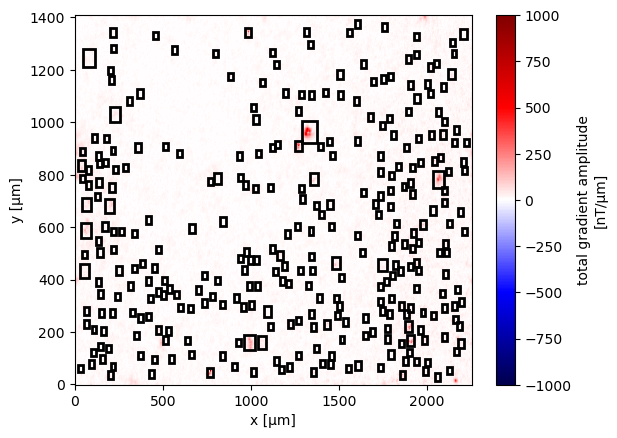

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

660 potential sources detected within 1.2779 seconds


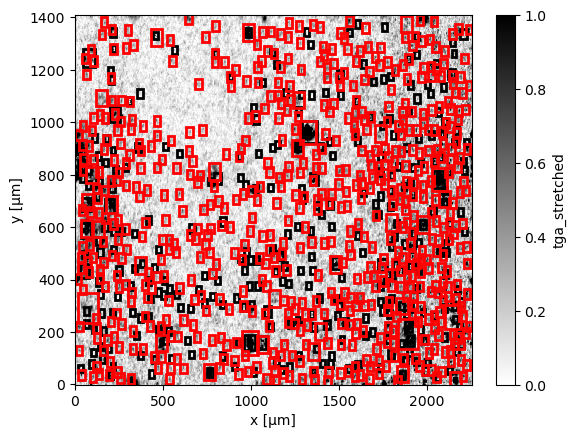

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [37]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[2209.41522369 2246.18477631  442.21522369  478.98477631]
[1417.46522369 1454.23477631   -4.28477631   32.48477631]
[2209.41522369 2246.18477631  327.06522369  363.83477631]
[301.21522369 337.98477631   2.76522369  39.53477631]
[1542.01522369 1578.78477631 1368.11522369 1404.88477631]
[4.15223689e-01 3.71847763e+01 9.33365224e+02 9.70134776e+02]
[1943.86522369 1980.63477631 1372.81522369 1409.58477631]
[ 627.86522369  664.63477631 1375.16522369 1411.93477631]
[1271.76522369 1308.53477631    2.76522369   39.53477631]
[  7.46522369  44.23477631 202.51522369 239.28477631]
[ 63.86522369 100.63477631 512.71522369 549.48477631]
[2030.81522369 2067.58477631  684.26522369  721.03477631]
[ 61.51522369  98.28477631 891.06522369 927.83477631]
[2021.41522369 2058.18477631 1365.76522369 1402.53477631]
[167.26522369 204.03477631 150.81522369 187.58477631]
[1231.81522369 1268.58477631  956.86522369  993.63477631]
[ 190.76522369  227.53477631 1064.96522369 1101.73477631]
[1398

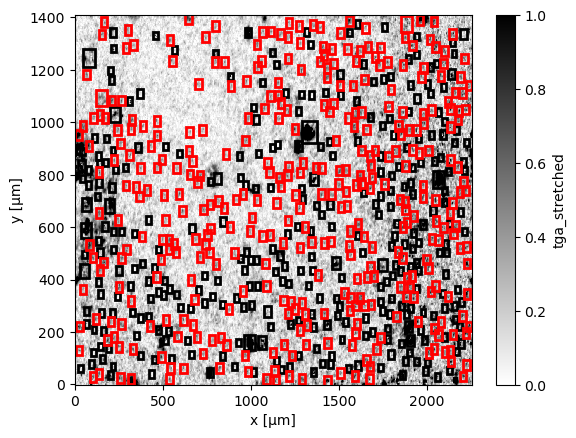

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 2.23030967e+03  4.60540298e+02 -1.51727684e+00]

[ 2.75296891e-15  4.33693637e-16 -1.67021024e-15]

(30.93438628811769, 81.04738950575467, 3.2490814440691758e-15)

0.8655384990023345

[1.43673917e+03 1.45141676e+01 1.24001969e+00]

[-1.21393661e-15  4.06902491e-16  8.11954881e-17]

(-3.628739461042032, -71.46923273269252, 1.282889100470652e-15)

0.8273737025614165

[ 2.22468649e+03  3.40644818e+02 -1.51550272e+00]

[-2.95681657e-16 -2.96455681e-15 -8.92979425e-16]

(16.685122770604785, -174.30421864054838, 3.110214937926683e-15)

0.7400186454915749

[325.81011503  14.58403122 -16.03985733]

[ 9.65121099e-14  1.89301517e-14 -1.08848773e-14]

(6.31543304445322, 78.90272768293075, 9.895159701254601e-14)

0.9835097218979751

[1562.29766196 1385.23148831   -6.80046295]

[ 6.06683012e-15 -6.36585845e-15 -2.76389456e-15]

(17.447988127341983, 136.3778000303814, 9.21790076628851e-15)

0.9235688684346164

[  8.95793584 938.38374957 -16.58593553]

[-3.00563673e-15 -1.10329506e-13 -3.19940177e-15]

(1.6604165103772723, -178.43951339299133, 1.1041680096384692e-13)

0.8287575308197472

[1962.22704834 1388.44108754   -8.63713479]

[-1.15260769e-14 -2.84668118e-15 -1.35021002e-14]

(48.67480956373111, -103.8731359879523, 1.7979453617605116e-14)

0.7698907148492566

[ 646.26378858 1393.09355557   -5.53328966]

[-5.89598783e-15  3.38448790e-15  7.40150874e-16]

(-6.213450114041019, -60.142780838814495, 6.838512567646756e-15)

0.8704068849307708

[1290.65796378   18.32226257   -8.528065  ]

[ 1.05057092e-14 -4.22141801e-15 -5.25793711e-16]

(2.6588787490149146, 111.89131362642297, 1.1334317557043204e-14)

0.9465185093530127

[ 29.02406085 218.88514155  -8.58887456]

[ 8.86242162e-15  6.33817828e-15 -1.00786812e-15]

(5.284931646844451, 54.428615267925174, 1.0942157880455264e-14)

0.9271805666454305

[ 76.82618828 526.49643397 -19.58837042]

[ 9.53714287e-15 -7.96975234e-14 -2.31313240e-14]

(16.07607462945378, 173.1760506239502, 8.353269112060439e-14)

0.9666895153442376

[ 2.04270776e+03  7.02138801e+02 -2.45663675e-01]

[-1.50584357e-15 -8.51247995e-17 -1.04362209e-16]

(3.9582347551403316, -93.23546647919488, 1.5118540129907245e-15)

0.6989008859511415

[ 72.98212484 912.75678033 -11.34640784]

[2.09768407e-14 4.83525767e-15 6.58293060e-15]

(-17.003640860034565, 77.01978119693106, 2.2510942587202613e-14)

0.9355760147696428

[2038.44667446 1384.87885364   -4.53338325]

[ 1.23489417e-15 -1.32291031e-15  3.64753161e-15]

(-63.61183547126766, 136.9708169924922, 4.0717983934099324e-15)

0.8337387351065393

[188.26986302 166.25400481  -7.12867388]

[-1.97093563e-15  5.88116088e-15  3.70267960e-15]

(-30.83521596709599, -18.52739010031019, 7.223743962899686e-15)

0.8921108027709108

[1250.67133924  977.50699841   -5.26192582]

[ 1.94787586e-15  3.21808851e-15 -2.31247632e-15]

(31.580869470245208, 31.1860880546026, 4.41563820524462e-15)

0.8752329141971187

[ 205.60264707 1080.44431434  -14.61759875]

[-8.11542298e-15 -2.39837203e-14 -7.80817224e-15]

(17.138992113159844, -161.30561257197172, 2.649615982601205e-14)

0.9544960896447696

[1416.62143211  270.84715053   -5.46754214]

[ 2.40582964e-15 -4.04989342e-15  1.07492833e-15]

(-12.854449477298756, 149.28767047681077, 4.831679196933213e-15)

0.9044484091276475

[ 541.72966299 1316.51156032   -8.91304039]

[ 5.78727564e-15  6.38051133e-15 -2.11049425e-15]

(13.766481837623472, 42.20877688403895, 8.86891594625207e-15)

0.9624301567417184

[ 1.08718739e+03  2.01528810e+01 -8.56046760e-01]

[-1.83429103e-15  4.65174369e-18  2.57705610e-16]

(-7.9973041185529965, -89.85469878802718, 1.8523113672840036e-15)

0.770068764904728

[1677.34287321  752.89570914   -3.02771591]

[-2.40075765e-16  2.37265459e-15 -1.06782168e-15]

(24.121270978742977, -5.777777673361169, 2.612923515915966e-15)

0.8478204826577347

[2172.05988464  830.72802117   -3.77524395]

[-3.06795111e-15  6.35259989e-16 -1.26465040e-15]

(21.98150871767384, -78.30147097510951, 3.378641718708057e-15)

0.7514263098507918

[1440.37462024 1172.1478297    -5.61063829]

[-4.33861566e-15  7.33031866e-16  1.85509576e-15]

(-22.860416455157516, -80.41014345561581, 4.775175575888808e-15)

0.7824409479433423

[1031.48837248 1303.15958814  -14.20707038]

[ 3.97325916e-15 -8.35311489e-15  1.22069116e-14]

(-52.84652723653772, 154.5613434838731, 1.5315678473793596e-14)

0.8979630742829989

[1702.73824497  413.72475054   -8.07077808]

[-8.02629613e-15  2.32414305e-15  1.36993078e-15]

(-9.310550694471015, -73.85077715878394, 8.467572305949487e-15)

0.9141820686064904

[1431.33369728 1204.93203297   -9.53802128]

[-7.36848740e-15 -7.66741489e-15 -3.52815996e-15]

(18.35472358957909, -136.1389424690836, 1.1204096137767034e-14)

0.9647413321552358

[ 316.71537519 1010.95029839   -7.0674817 ]

[ 2.26032082e-15 -5.76165833e-15  1.89505281e-15]

(-17.024001179966106, 158.5797310557865, 6.472787810759841e-15)

0.8221484984198417

[615.6762333  656.47169984  -7.42434526]

[-5.06459378e-15  3.88197008e-15  1.28511184e-15]

(-11.386494990089469, -52.53012772438304, 6.509325183911631e-15)

0.8940293563295244

piorou

[2.22529655e+03 2.04636314e+02 1.89620495e+00]

[ 1.50116609e-16  3.42124457e-16 -8.36802144e-17]

(12.62461923283494, 23.690798354372646, 3.8286618936803795e-16)

0.09915380795283468

[1497.74790491  767.42630253   -3.14168943]

[ 1.61853717e-15 -1.55557369e-15  9.91777227e-16]

(-23.835641634371097, 133.86359714091893, 2.4541992874183143e-15)

0.8547986517408538

piorou

[ 2.04945778e+03  1.29274962e+03 -1.06595675e+00]

[ 2.48639545e-16  1.65324563e-15 -1.07692826e-15]

(32.78794222027886, 8.552886916505821, 1.988672223780522e-15)

0.48012285670740795

piorou

[ 1.99921357e+03  4.75901116e+02 -1.72150253e+00]

[ 1.42210521e-16  1.37918816e-16 -2.24289886e-15]

(84.95243478386169, 45.87772788731629, 2.251630683941285e-15)

0.6037843959856805

[1631.300421    893.70162212   -6.20459188]

[-5.40866578e-15 -1.74719590e-16  1.24702826e-15]

(-12.976757767949575, -91.85021881099914, 5.553311795538493e-15)

0.89149280486103

[1508.46294656  818.8259723   -14.46079664]

[ 2.16391823e-14  1.35934334e-14 -7.19699622e-15]

(15.728947081729938, 57.8635331035313, 2.6548679733311216e-14)

0.9573736026489892

[1688.64983943  302.21323052   -9.24579422]

[-4.67289873e-15  7.41064747e-15  4.25064189e-15]

(-25.881839004143497, -32.234117146291574, 9.737640117553757e-15)

0.8218867857249931

[537.62831971 548.76490588 -13.84326668]

[ 1.25344492e-14 -1.98563689e-14 -4.13263578e-15]

(9.981511414679893, 147.73759062321693, 2.3842535176512106e-14)

0.964366615715023

[1669.58223648 1288.33936776  -13.75005107]

[ 1.18257641e-14  1.89169419e-14 -2.98343599e-16]

(0.7661784189620569, 32.011209941928605, 2.2311172064018406e-14)

0.97441782209562

[1603.21072809  611.21380446  -14.37701356]

[2.21267406e-14 1.75510743e-14 8.05713533e-16]

(-1.634120183497991, 51.578320578646014, 2.8253885220979558e-14)

0.9263779285335809

piorou

[1.97900041e+03 9.92527716e+02 1.15906809e+00]

[ 4.74256691e-16  6.03251842e-16 -2.08860983e-16]

(15.226107406469588, 38.17326078577508, 7.952704598350348e-16)

0.3199444994870072

piorou

[ 1.86355459e+03  4.81219928e+02 -2.29531535e-01]

[-1.29864281e-15 -7.58428139e-16  3.21238116e-16]

(-12.057447672864416, -120.28561066102851, 1.5378167353151543e-15)

0.5021613657184969

piorou

[2.05108994e+03 6.20918893e+02 1.39312176e+00]

[ 6.92775517e-16 -1.26957408e-16 -1.55398164e-16]

(12.442285806507234, 100.38474205940484, 7.212521683930038e-16)

0.3940179620365679

[ 2.23862353e+03  2.20617098e+02 -6.43579841e-01]

[ 1.45735607e-15  1.28520101e-15 -3.93600420e-16]

(11.45108456730037, 48.59184258378324, 1.982561382054088e-15)

0.8180984264567074

[  69.47244754 1175.67392217   -8.71275961]

[-4.80957608e-15  2.30966522e-15  4.47479556e-15]

(-39.986492048228214, -64.34864776774181, 6.963502767323242e-15)

0.9031567863194406

[732.37484266 670.28936936  -8.9792682 ]

[ 3.00840611e-15 -8.55470234e-15  1.47793050e-15]

(-9.256583787066818, 160.62491172818923, 9.187911519017769e-15)

0.9551475892609067

[ 1.53351947e+03  3.46371604e+02 -1.35269921e+00]

[-3.45770402e-16  1.72670880e-15 -2.25197354e-16]

(7.287500281450595, -11.323608021558316, 1.7753293462990965e-15)

0.8473482795089622

[1161.90478291  798.59990454  -11.31050265]

[-7.64780421e-15  1.04699932e-14 -4.73729622e-15]

(20.07084285674096, -36.14625194564808, 1.380404445427613e-14)

0.8729171956832641

[1216.47464285   36.70361501   -6.5724516 ]

[-5.81552740e-16  4.33062766e-15 -1.65123180e-15]

(20.70154833109051, -7.648397930891615, 4.671092591490302e-15)

0.7830755194129215

[2.12113431e+03 1.07476230e+03 4.75414343e-01]

[-9.58567012e-16 -3.93186015e-16  3.47548266e-17]

(-1.9212542817676306, -112.30250874988266, 1.0366551287391587e-15)

0.6709866744746091

[986.19503621  52.75232245  -3.10249878]

[-1.96146394e-15 -9.72135651e-16  6.39567137e-16]

(-16.285873818505294, -116.36381549967886, 2.280665391235126e-15)

0.8057839325234706

[2103.55395668 1227.15431984   -6.18664244]

[-1.18395986e-16  2.04009979e-16  3.16936178e-15]

(-85.7436689144881, -30.128483228156252, 3.178127090148421e-15)

0.5964720686882002

[1213.54889798  801.03532549  -10.98740612]

[ 6.82922414e-15  1.05620647e-15 -6.81644189e-15]

(44.60775149930047, 81.20830248708074, 9.706583048918623e-15)

0.8272758367256896

[1619.33650295  341.39815972   -4.40064297]

[ 3.14394094e-15 -2.25598663e-15  1.35626998e-15]

(-19.315214911227443, 125.66195403662589, 4.100403468965248e-15)

0.5496093596725453

[1167.7628092   753.35409109   -9.91119983]

[-7.21883412e-16  1.07398265e-14  2.14443828e-15]

(-11.267068069294366, -3.8453836016476295, 1.0975591277761315e-14)

0.9745289399200288

[156.71807994 460.79043323 -10.56231827]

[ 1.56417554e-14 -3.76242890e-15  4.67794841e-15]

(-16.213079111564124, 103.52484950412621, 1.6754210955729417e-14)

0.8674585227864515

piorou

[1.92222089e+03 3.39662336e+02 6.36991563e-01]

[5.66078649e-16 3.33038905e-16 5.40934367e-16]

(-39.475408784681534, 59.53058531725582, 8.508642307964067e-16)

0.20427283357623316

[262.38808909 227.28341423 -10.08467234]

[ 1.29796164e-14 -2.72102486e-15  8.63502013e-16]

(-3.7253924639030243, 101.83992972865622, 1.3289847751500645e-14)

0.9494868293698685

piorou

[2.02399296e+03 3.57825848e+02 1.73183362e+00]

[7.68402984e-17 4.59352623e-17 2.88631856e-16]

(-72.76791620722607, 59.12894530951129, 3.021966710830518e-16)

0.12800670071177733

[1321.2611214   225.18136002   -4.94898456]

[ 3.91535063e-15  6.04247494e-16 -1.59082813e-15]

(21.878009107211817, 81.22688081682801, 4.269170844037812e-15)

0.8829814061720603

[1943.28223876  971.66357071   -3.51287472]

[ 7.49866940e-16 -3.49349343e-16 -1.47321408e-15]

(60.68454748042947, 114.97995376097515, 1.6895872635732354e-15)

0.5254190909411599

[1729.40542017 1217.63016593   -4.5928644 ]

[-3.23115852e-15 -1.53041341e-15 -3.19397000e-16]

(5.104971811619539, -115.34421556924593, 3.589507629350358e-15)

0.9218369706803432

[259.66315287 919.48000585  -4.94975808]

[-2.91863967e-15  1.99977447e-15  4.55745531e-16]

(-7.340071694541367, -55.58209227043695, 3.567248165546263e-15)

0.9108863600357713

[1680.39972668   65.31243049   -7.61385816]

[ 3.49911855e-16 -6.16695780e-15 -2.23260781e-15]

(19.872190099113762, 176.75253181324527, 6.5679787190260614e-15)

0.7710807244201733

[1152.27531126 1154.21818033   -7.78726635]

[ 1.77202942e-15 -3.89465178e-15  3.53257334e-15]

(-39.5428406396521, 155.534917569848, 5.548646248549266e-15)

0.9334267475800269

[1905.8563399   374.33416933   -5.98440758]

[ 2.29390372e-15 -4.51619379e-15  1.36134349e-15]

(-15.043060058553714, 153.07268502230357, 5.2451174176140476e-15)

0.8310406175145103

[ 1.59117207e+03  9.83189862e+02 -1.53507060e+00]

[-1.71814954e-15  2.94311524e-19  1.43484903e-16]

(-4.773767935521658, -89.9901854829181, 1.7241304604282525e-15)

0.4413283269947367

[1847.93758592  991.53052022   -4.58370036]

[3.51235124e-15 1.85881981e-15 1.08727392e-15]

(-15.301876997799134, 62.11114228784532, 4.119949870575459e-15)

0.7205455425625713

[2164.03012347 1116.10073546   -4.114339  ]

[-2.40538447e-15 -2.57991663e-15  1.05921544e-15]

(-16.714525076550697, -137.00506917627268, 3.682903970023894e-15)

0.905894279216917

[1542.85582812  815.4712168    -9.4234529 ]

[-7.53410256e-15  7.12314010e-15 -5.56722088e-16]

(3.0735218935329547, -46.60604883099795, 1.0383244471749654e-14)

0.9331381950913468

[267.04890379  22.56342768  -9.45705432]

[-9.69198471e-15 -1.13936489e-15  4.60135240e-15]

(-25.244422321615907, -96.70477193280962, 1.0789122481858729e-14)

0.8260311103259977

[589.22532111 723.07656975  -5.96410049]

[-4.09905979e-15 -2.70843943e-15 -8.78411239e-17]

(1.0242929570563497, -123.45459448836878, 4.913822481233118e-15)

0.9235743778655356

[134.89315979 647.92354541  -9.77463927]

[7.03300471e-15 1.12792905e-14 7.75355151e-16]

(-3.3383429680480705, 31.94488198258644, 1.3314906140912856e-14)

0.8841279931713137

[1429.62257627  163.60340843   -6.40395215]

[-1.59810676e-15  4.30827381e-15 -1.86872476e-15]

(22.130373610966576, -20.351781381463923, 4.960574634790794e-15)

0.5626862510459085

piorou

[2.21959932e+03 7.45650668e+02 1.98655258e+00]

[ 3.66227635e-16  4.29514035e-17 -1.51931013e-16]

(22.393132063109544, 83.31087294897267, 3.988114051766502e-16)

0.17650194876432146

[266.1705998  476.45732227  -6.29446296]

[-2.22940193e-15  4.29827030e-15  2.33616269e-15]

(-25.75613752642018, -27.414605000828537, 5.376152584705389e-15)

0.8730051752246323

[ 1.69485514e+03  5.21225561e+02 -4.81128224e-01]

[ 1.28940700e-15 -3.61155561e-16 -3.56827906e-17]

(1.5264692979347014, 105.64725687622362, 1.3395062611389274e-15)

0.5750271028527614

[1880.94548104 1322.52846022   -4.1378592 ]

[-1.95784206e-15  2.46733465e-15  1.03113865e-15]

(-18.127009820503122, -38.43217143760632, 3.3142318483116194e-15)

0.7912044683925757

piorou

[1.87876356e+03 6.61635948e+02 1.69223216e-01]

[ 6.03082313e-16 -1.53848803e-16 -7.83017578e-16]

(51.51988354415328, 104.31115493670255, 1.0002470983890004e-15)

0.4845000904248451

[433.28962229 224.01470281  -7.06677037]

[ 6.23168584e-15  2.78648167e-15 -5.13446366e-16]

(4.30145388617298, 65.90832158473543, 6.845583665410016e-15)

0.9210226871322419

[1590.37835673   36.48765934   -6.66216966]

[-5.90247222e-16  5.26216569e-15 -3.17667999e-15]

(30.96041942164623, -6.40000825621658, 6.1749554890297615e-15)

0.8642026046945332

[1282.66499868 1208.60727057   -7.68951542]

[-5.40534021e-15 -1.79615059e-15 -1.18848867e-15]

(11.785951066880244, -108.3812275920318, 5.818622262027671e-15)

0.8530352205703029

[1883.46535318  334.24534763   -7.87552041]

[-5.08357214e-15 -4.21201689e-15 -2.91358495e-15]

(23.8133907367937, -129.6436019472334, 7.216146423608356e-15)

0.7451471535609795

[706.05161256 484.10141213 -13.11658318]

[-8.34758718e-15 -1.27478863e-14 -7.04139116e-15]

(24.801657833528267, -146.78236748421324, 1.678606580710476e-14)

0.9181366205281803

[1418.58463835 1283.10075797   -9.47385657]

[ 7.71276346e-15 -3.91337308e-15 -2.56255632e-15]

(16.50410579479846, 116.90274628084786, 9.020415954868513e-15)

0.799110841206481

[1668.61562966   16.57164763   -2.33396129]

[-2.05530295e-15  6.86896837e-16  3.43124478e-16]

(-8.99736336892033, -71.52000625141767, 2.1940446452197838e-15)

0.6991487103521586

piorou

[ 2.07795541e+03  1.17399976e+03 -3.62868889e-01]

[6.80472630e-17 1.04853403e-15 7.01554216e-16]

(-33.73010406951986, 3.713147217081616, 1.2634208985931283e-15)

0.4668817412286633

[2161.90870108  606.90400997   -4.0283086 ]

[2.92745825e-15 2.70232615e-16 1.03399579e-15]

(-19.377318613838337, 84.72599343066588, 3.1164378333698187e-15)

0.6895709643803835

[283.59900852 516.91602265 -10.27348064]

[ 1.01661495e-14 -5.38637566e-15  1.42609715e-15]

(-7.0660673494954604, 117.9161816054003, 1.1592988859135894e-14)

0.7599087570216146

[2138.91835432 1055.01163199   -2.63900404]

[-1.30765198e-15 -1.02283373e-15  7.82647804e-16]

(-25.24051055699533, -128.03220090762838, 1.8353964546261506e-15)

0.686440151108276

[ 2.19992133e+03  1.11033491e+03 -4.73670119e-01]

[ 1.28020898e-15 -2.96178910e-16 -1.77296817e-16]

(7.684323203915762, 103.02631474798363, 1.3259302930943278e-15)

0.5122335572757774

[1625.76940295  792.5984625    -9.88990812]

[ 1.13398003e-14 -2.94409490e-15 -5.18770979e-15]

(23.883665719932708, 104.55408532896712, 1.2812927031635037e-14)

0.8339253537545227

[1979.04042127  714.05877481   -6.85356469]

[ 8.92652734e-16 -1.44213152e-15 -3.65631049e-15]

(65.11491533651966, 148.2432587366265, 4.030530810225289e-15)

0.748184120432903

[812.80695287  64.99592236 -13.29055863]

[ 1.19439692e-14 -5.66428291e-15  5.74775410e-15]

(-23.499855725371923, 115.37208087326674, 1.4414547481831486e-14)

0.8568506310851414

[1919.2409641  1287.35035193   -5.48887261]

[-4.26396142e-15  5.49089702e-16 -9.09574424e-16]

(11.945893191182238, -82.66214504043229, 4.394336369056053e-15)

0.784651937021518

[328.09608501 137.18265282  -5.13780715]

[ 3.30166498e-15 -2.32199738e-15  1.21121617e-15]

(-16.703034030511784, 125.11798183895363, 4.21422686179443e-15)

0.8948919788843743

[1735.3623411  1289.90988097   -2.34753152]

[ 4.04248255e-16  1.87179630e-15 -4.02814306e-16]

(11.8791081985555, 12.186885917610434, 1.956859062607425e-15)

0.7601444700734071

[1081.81499428  376.71363339  -11.41188521]

[-1.29560306e-14  4.11287170e-15 -9.61627736e-16]

(4.046557685794064, -72.38804033772858, 1.3627148256371331e-14)

0.8979923222684678

[492.95272362 103.77098786  -5.17202857]

[ 6.82545225e-16 -3.46670185e-15 -2.70796049e-15]

(37.467311363416776, 168.8617239964346, 4.451622149997695e-15)

0.7960663752192436

[2203.99827654  775.37307841   -4.07647034]

[ 3.24977909e-15 -7.80476505e-17  1.30679717e-15]

(-21.90026782020106, 91.37576782749817, 3.5035516867032008e-15)

0.8549295851289336

[250.00549157 362.62658153  -5.93628052]

[-1.88721778e-15  3.44566224e-15  1.32225547e-15]

(-18.6016172780562, -28.70988599657314, 4.145182597088193e-15)

0.6642799602217151

[1888.93520474  405.13282566   -7.39717915]

[-4.27432050e-15  1.27916157e-15  4.07292899e-15]

(-42.39235428523085, -73.33931216254105, 6.041094321494006e-15)

0.8624984047694754

[1442.68594791 1037.85908281   -3.11572432]

[1.67593087e-15 2.00360818e-16 1.33673556e-15]

(-38.378105072930346, 83.18253440747989, 2.153079354857564e-15)

0.67593673443693

[758.85632452 503.48632333  -5.77926372]

[ 2.00748059e-15 -2.40506510e-15  1.70929207e-15]

(-28.61754157794913, 140.14863015813506, 3.568752696980031e-15)

0.8905942015746032

[1776.52215614 1226.23621733   -9.71893096]

[-1.89554867e-15  3.72495253e-15 -5.81766907e-15]

(54.30585013009258, -26.970569773193766, 7.163354627630312e-15)

0.8730512896145197

[ 158.41426569 1332.97446926  -11.19016193]

[-9.90054413e-15  4.89070737e-15  3.43293540e-15]

(-17.269429013316916, -63.711379035316845, 1.1563945608686816e-14)

0.9745397438366157

piorou

[2192.98720535 1171.31620722    2.47870388]

[ 3.84782013e-16 -1.11385217e-16 -1.78426603e-16]

(24.009209714225957, 106.14446928002975, 4.3852014364190747e-16)

0.36687117682415105

[1206.60565278 1043.75971904   -9.21791725]

[ 9.11043658e-15 -2.73624977e-16  1.99366527e-15]

(-12.338239097801738, 91.72031765677427, 9.33003893497663e-15)

0.9355608919920638

[1602.43304925  232.81139293   -4.97755165]

[ 1.2320118e-15  2.5959764e-15 -1.6657922e-15]

(30.10131530800097, 25.38832065212329, 3.321416897879275e-15)

0.8528073129046247

[1398.42596509 1229.49417643   -9.01880651]

[ 4.80989140e-15 -4.39750553e-15 -3.64991697e-15]

(29.250959447419376, 132.43551955098718, 7.469605347619428e-15)

0.9594818753996246

[1864.64889203  609.18380411   -8.947547  ]

[ 6.49350224e-15  5.25047572e-15 -3.47710404e-15]

(22.606263707420645, 51.04190416686189, 9.045624306515976e-15)

0.6994392371262635

piorou

[ 2.14429071e+03  1.33754997e+03 -1.64631882e+00]

[ 2.94606763e-15 -2.93379865e-16 -2.70452555e-16]

(5.219447324199661, 95.68696742583437, 2.9729666649947072e-15)

0.8262488605523012

piorou

[2017.28085465  125.28978022    2.56211353]

[-3.26514928e-16  2.58813339e-16  3.16376936e-18]

(-0.43505965975004773, -51.59775884548276, 4.16660955925206e-16)

0.09539813916971251

[693.00189357 180.19098941  -6.49824119]

[-5.01030331e-16 -3.94871433e-15 -1.79584633e-15]

(24.28371976173925, -172.7687001321849, 4.366742529014228e-15)

0.9038974999695817

[2033.8850936   134.70681726   -7.21608091]

[-6.36829639e-15 -1.66627494e-15 -1.21868375e-15]

(10.488691494229752, -104.66281827392723, 6.694539656594695e-15)

0.7877677586860985

[1394.33093082  722.85552308   -7.64859175]

[-6.54932766e-15 -3.04196776e-15 -1.06190772e-15]

(8.365505231835463, -114.9134656134583, 7.298966274507888e-15)

0.8025833528450474

[780.57968357 170.49407262 -10.38236241]

[-1.02484565e-14 -9.58570784e-16  9.56472286e-16]

(-5.308841705123392, -95.34351045634568, 1.0337531554766362e-14)

0.9679212586386386

[100.80455479  28.65399616  -7.29532414]

[ 6.89534950e-16 -3.71326751e-15  4.08100663e-15]

(-47.21744264663521, 169.48028773020883, 5.560434260792138e-15)

0.8985614076276576

[2215.66190075 1247.97043954   -4.75478553]

[-4.00267141e-15 -5.17077569e-16 -2.48610604e-17]

(0.3529335468285347, -97.36088121631185, 4.0360086361725425e-15)

0.8121579279971882

[ 553.94070057 1235.22394928    2.58561676]

[-2.12625040e-16  3.80722609e-17  1.48565803e-16]

(-34.51954113080414, -79.84830151275085, 2.6216541078804125e-16)

[979.91825933 928.45904306  -7.41451677]

[-5.45418869e-15  9.16839772e-16  2.61547885e-15]

(-25.30951262440116, -80.45788750589618, 6.117965264578728e-15)

0.6164421367509912

[1.65681251e+03 9.33088052e+01 3.13772219e-01]

[-7.93033217e-16  5.50331381e-16  3.42077585e-17]

(-2.029607420176151, -55.24099392511864, 9.658863714487624e-16)

0.7024772926799827

[ 704.10444361 1145.70626711   -2.37959854]

[-1.33990608e-15  9.30075816e-16 -1.65795215e-16]

(5.804073744631267, -55.234128587227985, 1.6394747252466748e-15)

0.8905809355098574

piorou

[9.70021932e+02 1.19798006e+02 5.60276486e-01]

[-2.81523811e-17 -6.43172696e-17  4.76969858e-16]

(-81.6263397891857, -156.36047239592625, 4.8210944125637445e-16)

0.2909350522411781

[1846.06023772  703.60819753   -2.8957427 ]

[-1.92351388e-15  1.26319174e-15 -2.02097313e-16]

(5.018968195506249, -56.70667404247115, 2.3100654448982406e-15)

0.7017679231276789

[1168.76619526 1071.41113758   -6.41266101]

[-1.70503879e-15  4.30881010e-15  1.04052571e-15]

(-12.655653660198972, -21.589195700217367, 4.749283678957811e-15)

0.8780962222745822

piorou

[1.88983421e+03 6.17738193e+02 1.84603098e+00]

[ 2.96952971e-16 -3.01415408e-16 -1.45564621e-16]

(18.98450256918911, 135.42728539622712, 4.474610306989087e-16)

0.26422967403511655

[1317.99770397  151.58017466   -9.21638271]

[ 7.22166485e-15 -2.67836976e-15 -2.46487234e-15]

(17.745495946761338, 110.34880082944609, 8.08713196313909e-15)

0.9072398803291908

piorou

[976.58799091 996.0420358   -3.42434388]

[ 3.04584298e-15  1.04417306e-15 -2.91119517e-16]

(5.1662878876026035, 71.0773075800989, 3.2329873760849016e-15)

0.27345163276090156

piorou

[ 4.61831917e-16  3.18384751e-16 -3.22416041e-16]

(29.88919426968334, 55.417803093905086, 6.470005203070026e-16)

0.12097183774521869

[1694.02802182  793.35505209  -10.34099839]

[ 8.06072934e-15  4.77356840e-15 -3.33027635e-15]

(19.56974357060157, 59.36595905607452, 9.942487284651878e-15)

0.8872466579781411

[ 42.58541074 992.71711548 -11.45675712]

[-6.16401134e-15 -1.76121072e-14  4.36100041e-15]

(-13.154665300517898, -160.71060933580176, 1.916245501443825e-14)

0.8899875768687582

[1031.10493064 1206.0757455   -12.28928601]

[-1.25964865e-14 -7.83058007e-16 -6.27833862e-15]

(26.448487061775445, -93.55720289620184, 1.4096176382261361e-14)

0.7781798255486679

[1170.02825426 1339.76908385  -11.60605701]

[-9.29434166e-15 -9.10371759e-15  2.32655644e-15]

(-10.13886571164558, -134.4063741175276, 1.3216479327303702e-14)

0.909873038968024

[2103.7396873  1273.37643521   -6.98334876]

[ 1.00564006e-15  3.64539568e-15 -2.78352093e-15]

(36.35592100532999, 15.422360944132528, 4.69555218974413e-15)

0.7863964239739935

[1672.03870466  832.95133408  -12.13974713]

[-1.32381595e-14  1.24767548e-15 -8.07037647e-15]

(31.255242794428042, -84.61586831207636, 1.555430931508423e-14)

0.834378264496824

[1984.24750716  759.49791038   -4.89140066]

[ 3.44269749e-15 -2.99486546e-16 -1.28660282e-15]

(20.42096782196971, 94.97174841194834, 3.68743881505923e-15)

0.7691872270255466

[1273.82504035  522.736093     -6.33767016]

[ 3.77290175e-15 -1.49117416e-15  2.11791480e-15]

(-27.566958352627875, 111.56555241210597, 4.576456166155932e-15)

0.9446055971682302

[379.69741911 983.60427367  -3.94248588]

[-1.98038551e-15 -1.15893880e-15 -6.05812833e-16]

(14.789740260492099, -120.33654154039347, 2.373199339527462e-15)

0.8739253881303143

piorou

[1229.09130943  100.55847785    1.38957967]

[-3.80382151e-17  2.58591440e-16  3.22986131e-16]

(-51.01874088515013, -8.368068377955723, 4.154954629164697e-16)

0.1863914326071795

[711.52749235 794.65027162 -12.04704195]

[-1.41283556e-14  4.37071573e-16 -4.14296145e-15]

(16.335709358716098, -88.22807599646629, 1.4729751934438832e-14)

0.8571823372033958

[1729.59539649  181.51847257   -6.5378344 ]

[4.32382502e-15 6.34563192e-16 7.95251212e-16]

(-10.313477551398949, 81.65089122746025, 4.4419092406061234e-15)

0.6222782139500653

[1562.93890165  330.84839434   -5.48382146]

[2.73833782e-15 1.33401150e-15 1.01212171e-15]

(-18.380594182995612, 64.02646015120433, 3.2097462585863364e-15)

0.6688340216505098

[1000.40886398  586.78434756   -3.27984498]

[-2.11469057e-15  7.76958776e-16 -2.36442899e-17]

(0.6012984376347555, -69.82615559973604, 2.253029114849061e-15)

0.787028895610677

[ 468.979932   1003.43361909   -2.19889738]

[-1.25961364e-15  6.91729176e-17  4.03360291e-16]

(-17.73134644417943, -86.85670338067, 1.3244285291058522e-15)

0.8260061543054306

piorou

[1458.09206831  724.43362066   -1.49881238]

[-1.08210887e-15  9.32182085e-16  3.88878233e-16]

(-15.230962405972752, -49.25676390645151, 1.4802531261976096e-15)

0.5578842108077767

[1267.92291918 1362.26136296  -10.26033304]

[-5.27998116e-15 -6.21784027e-15  1.33755827e-15]

(-9.312088678154593, -139.6632023601602, 8.266123684005498e-15)

0.8523014522655773

[1862.88971167  961.43413544   -6.07629086]

[ 5.99169915e-15  1.55913374e-15 -1.43591312e-15]

(13.057575047184086, 75.41421224812977, 6.355564747105188e-15)

0.7429757977935663

[1843.20847182  371.39529459   -8.54692978]

[-4.42873311e-15 -3.49623245e-15  2.28987992e-15]

(-22.088804773288707, -128.289080870481, 6.0894062405759974e-15)

0.579762378142608

[ 108.35420719 1018.07890086  -10.40607988]

[-1.32205790e-15 -7.83390682e-15 -3.33633943e-15]

(22.77979421374286, -170.42096459351555, 8.616791393550585e-15)

0.8767115721148611

[1557.70327428  586.47945043   -7.45659632]

[ 6.34852235e-15 -2.73442821e-15  1.02773005e-15]

(-8.45677825957738, 113.30245540281624, 6.988351929168603e-15)

0.8366866333486598

[2136.88804131  128.96129465   -8.18033255]

[ 8.22342821e-15  2.70885437e-15 -3.14653121e-16]

(2.0813306678236185, 71.76775798890696, 8.663813835012909e-15)

0.8872974362314038

[1336.84378319  544.7496044    -5.01646617]

[ 3.49942501e-15 -2.81959164e-15 -2.44616214e-16]

(3.1156312611628496, 128.85943459552803, 4.500656566388491e-15)

0.852242965010639

piorou

[ 2.19700431e+03  2.62182644e+02 -7.99092702e-01]

[ 1.24628841e-15  3.30971824e-16 -2.98700227e-16]

(13.042120792681201, 75.12747581649172, 1.3236309782223487e-15)

0.24184026634891576

[1057.92373507 1232.71384194   -6.03814805]

[ 7.94636030e-16 -1.49926537e-15  2.60819434e-15]

(-56.95286716222617, 152.07565298250964, 3.1115785037246595e-15)

0.8653029724561263

[2138.58873548   93.76642778   -3.39552251]

[-1.51396926e-15 -2.65593489e-15  1.76420524e-16]

(-3.302746869281763, -150.31545347049257, 3.0622242349210338e-15)

0.526494024396627

[1083.72137005 1052.65322511  -10.48295605]

[ 9.98037566e-15 -1.19011260e-15 -2.21006915e-15]

(12.4010617893687, 96.80014070818768, 1.0291193902360047e-14)

0.8831264947327662

[809.12384644 454.89395373 -10.85378495]

[ 1.03316677e-14 -7.56246104e-15 -1.82379288e-15]

(8.10684060650376, 126.2029733036746, 1.2932919030092891e-14)

0.9184771088536446

[ 96.78342642 482.57454185  -3.90032119]

[-1.86005610e-15 -1.31260105e-15 -1.65976382e-15]

(36.09452735955021, -125.20978541662993, 2.817365105598601e-15)

0.7581517563611256

piorou

[1118.44015004  584.43619655   -1.16426045]

[ 1.66850135e-16  9.22768446e-16 -1.75978561e-16]

(10.628738094485907, 10.249183346156642, 9.5410116126937e-16)

0.13579933459764237

[1950.26276813  242.08319583   -1.95344582]

[-5.53554366e-17 -3.90135942e-16  1.40707529e-15]

(-74.35539673157598, -171.92434700686462, 1.4612087934639351e-15)

0.7729882068905833

[1306.83106901  603.0999       -2.86632243]

[ 1.47835537e-15 -1.05877672e-15  7.52502248e-16]

(-22.48118158566427, 125.60969022840827, 1.9679436889390877e-15)

0.8103337902716483

[ 262.26875887 1076.83560126   -6.50803423]

[2.47228925e-15 3.77850331e-15 2.20021350e-15]

(-25.978272207363915, 33.196878118771956, 5.022971321608411e-15)

0.8486909576174093

[1213.98013635  839.80920949   -9.25587413]

[-3.71505660e-15 -6.45273148e-15  2.16693672e-15]

(-16.226554086170445, -150.06950466925954, 7.75467625854277e-15)

0.8281867557589431

[404.65911756 744.59818727 -13.06978285]

[ 1.58908893e-14 -5.93719736e-15 -6.05654660e-16]

(2.0447489730688972, 110.486830697254, 1.6974613219284483e-14)

0.9074502917559318

[1208.1158808   272.37841887   -9.51364963]

[ 7.25531830e-15 -1.08158836e-15  3.84182478e-15]

(-27.642438685153376, 98.47894000490909, 8.280645787771879e-15)

0.8937491769305461

[1598.69689646  197.85645346   -2.89409006]

[ 2.30072856e-15  1.79537142e-17 -2.79563719e-16]

(6.9278914911525655, 89.55290198505861, 2.3177208905470967e-15)

0.9020414280006497

[1416.02265791 1068.51126762   -2.41190788]

[-8.99652441e-16  8.55884503e-16  6.97459364e-16]

(-29.322053448170106, -46.428166311319906, 1.4242058700734215e-15)

0.5412077071238688

[ 1.88194606e+03  8.35679236e+02 -1.86373630e+00]

[ 2.12220347e-15  3.77162038e-17 -4.90912234e-16]

(13.022693760669572, 88.98183569570226, 2.1785694655591713e-15)

0.8053990735877216

piorou

[1.76505740e+03 7.67385843e+02 1.94452375e-01]

(-80.29849445831906, -130.35925804207196, 6.787623642141357e-16)

0.3039128566405632

[218.12655243 854.84627592  -2.80682893]

[ 1.71963708e-15 -2.13329303e-16  4.67931722e-16]

(-15.111752058136629, 97.07168961363958, 1.7948875131412484e-15)

0.8074742806333562

piorou

[1.71363130e+03 1.32551268e+02 1.00814878e+00]

[4.67036369e-16 9.32878457e-17 2.36972362e-16]

(-26.45342752026371, 78.70415607845152, 5.319600475315663e-16)

0.1387630685868626

[2193.40628707  731.29607333   -2.776662  ]

[ 1.50215232e-15 -8.58050135e-17 -8.11679036e-16]

(28.345292659278183, 93.2692613851487, 1.709575076247653e-15)

0.5386018581014479

[ 1.65816956e+03  4.09649014e+02 -5.28276978e-03]

[-1.02979644e-15  4.26238258e-16  1.85876372e-16]

(-9.468457920384422, -67.51507470238778, 1.1299158331074523e-15)

0.582747538867406

[2.17582614e+03 1.01656541e+03 2.00883525e+00]

[-5.46555102e-16  4.22047782e-18  4.92694130e-17]

(-5.150873987023004, -89.55757295173379, 5.487875428535342e-16)

0.19296280045771697

[1153.98276152 1101.31202578   -3.35541612]

[-1.00812716e-15 -1.34150339e-15 -1.05261364e-15]

(32.09892650775858, -143.07548291179373, 1.980895548799659e-15)

0.8246534994796632

piorou

[2.10080644e+03 1.21881913e+02 1.52261339e+00]

[-4.30746649e-16 -6.09675633e-17  2.92466100e-16]

(-33.91192190503137, -98.05608996618294, 5.242100144003501e-16)

0.48000687301159184

[2025.76713964 1311.03203401  -12.93418073]

[ 1.58506033e-14 -9.82475691e-15  5.09362194e-16]

(-1.5645768275520373, 121.79207878463495, 1.8655479731616263e-14)

0.9225840333415053

piorou

[1.86175284e+03 1.04154726e+03 4.62049823e-01]

[-7.89901127e-16  3.20894282e-16 -1.77627822e-16]

(11.768548059071405, -67.8907415931989, 8.709010126430376e-16)

0.23572929787693764

[1644.36633757 1158.19582264  -12.31718949]

[ 1.31863986e-14 -6.92873868e-15  1.20205431e-15]

(-4.613592580450791, 117.71949567879595, 1.4944345522579292e-14)

0.9084564230547024

piorou

[2223.57651324   84.68746555   -2.73042738]

[-8.24370013e-16  2.24622697e-15  2.37599547e-17]

(-0.5689336367163302, -20.153242788817813, 2.3928405831799385e-15)

0.2811028821787298

[1103.16401107  814.97501517   -5.07914181]

[-2.57896889e-15  1.94865862e-15 -3.34075428e-16]

(5.900707184875208, -52.925451011423505, 3.2496087989921728e-15)

0.7646361028386045

[ 2.03825006e+03  5.54671360e+02 -1.88234594e+00]

[-1.94001068e-15 -1.10484893e-16  5.65372362e-16]

(-16.22267113477022, -93.25951168363864, 2.0237327520890983e-15)

0.71088334773885

[ 4.62084103e+02  4.09021662e+02 -2.13888668e-01]

[ 7.05175911e-16 -4.86584573e-16  1.02200110e-16]

(-6.802483907791631, 124.6064018416606, 8.628339787494696e-16)

0.6411569300471516

[ 154.19953671 1090.56738416  -14.13860273]

[ 1.81963426e-14 -1.72004928e-14 -6.38379293e-15]

(14.302941844905009, 133.38847336211032, 2.5840213748884517e-14)

0.8415005990048876

[ 1.92171285e+03  8.95886701e+02 -1.36339068e+00]

[ 5.39398710e-16 -1.62311635e-15 -2.65847925e-16]

(8.834821026468497, 161.61717188405075, 1.7309340755323698e-15)

0.7201086854717054

[429.57209078 912.94346722  -4.497872  ]

[ 1.33542781e-15 -1.09744100e-15  1.36694571e-15]

(-38.337775319626765, 129.4130180486139, 2.203697972428334e-15)

0.8548709295782858

[288.53285623 761.87040193  -5.24177424]

[-4.33474551e-16  2.85996139e-15  5.43911237e-16]

(-10.649197575053828, -8.618528368454848, 2.943317647425876e-15)

0.7561442123991089

[1643.76258334  563.37510248   -4.88521563]

[ 1.61627496e-15 -1.86727514e-15  1.19157226e-15]

(-25.756873993983834, 139.12120974536987, 2.7420623022802484e-15)

0.7564639917934866

[ 1.25040030e+03  2.86380549e+02 -7.19036900e-01]

[5.24801452e-16 4.13681836e-16 6.01795113e-16]

(-42.00502191680657, 51.75257687496978, 8.992811483916081e-16)

0.7514265128583154

[2008.45458456  444.62995757   -6.53635669]

[-3.76197604e-15  1.30020954e-15  2.36209164e-15]

(-30.686652280665065, -70.93388960620872, 4.6284430928284846e-15)

0.7156849641480236

[812.67269408 695.84092599 -14.37539348]

[8.17781814e-15 1.66031284e-14 3.55807696e-15]

(-10.88216749669982, 26.22240523699214, 1.8846763487422483e-14)

0.9092168577435522

[2134.19945425  854.54122818    2.498229  ]

[-1.36774232e-16 -2.96226853e-16 -2.08250085e-16]

(32.54842273227884, -155.2162262963264, 3.870731675153546e-16)

0.32560906418327584

[1136.13169884   16.88071103   -2.9404596 ]

[ 2.00458967e-15 -3.94007315e-16  1.16294569e-16]

(-3.258045070106598, 101.11988275725054, 2.0462516832643614e-15)

0.6470881370891071

[906.87220419 499.98940135 -10.08371331]

[ 6.22124632e-15 -6.32119746e-15  1.84484954e-17]

(-0.11917962211239659, 135.45658223239428, 8.869147840579074e-15)

0.9222192481803144

[1415.35070637 1258.17327425   -6.79460554]

[ 3.43213730e-15 -3.87787201e-15 -3.27969836e-16]

(3.62383229755577, 138.48934391972668, 5.188932638925222e-15)

0.9109902090153514

piorou

[1277.37188849  212.02143898   -2.3179983 ]

[-1.67598546e-17 -8.77099962e-16  1.47257430e-15]

(-59.21637706171021, -178.90531053790744, 1.7140770991392358e-15)

0.4228424834939688

[1673.32169053  871.32924413   -2.89936625]

[-8.43750139e-16  1.34166118e-15 -1.04065920e-15]

(33.28893361367006, -32.16515761143428, 1.8960328582925244e-15)

0.7794477032604541

[1157.05783234 1014.16538795   -1.21221182]

[ 1.23746630e-15 -5.45174071e-16 -5.73227745e-17]

(2.4273809798909256, 113.77621204671343, 1.353448747067749e-15)

0.6800880165405034

piorou

[ 2.18951382e+03  5.20475752e+02 -9.80591268e-01]

[-1.57478423e-15 -4.80849281e-16 -4.80390528e-17]

(1.6711529607407263, -106.97968206044892, 1.6472611048817652e-15)

0.4862454328629374

[2.06824256e+03 5.44299447e+02 1.00661986e-03]

[ 3.63038483e-16 -6.15626039e-16 -8.14964248e-16]

(48.75028107335635, 149.47188422126794, 1.083955296968329e-15)

0.5879009778280604

[1707.56255008  890.83810384   -6.80234997]

[ 1.03863596e-16 -5.38009303e-15 -3.56738209e-16]

(3.7928575310641564, 178.8940327670239, 5.392907452264904e-15)

0.9125512649678474

[1122.20781935  125.38871268   -5.45066618]

[ 3.06973190e-15 -7.88444516e-16  7.18566482e-16]

(-12.77427251950277, 104.4047509390799, 3.2498056042561297e-15)

0.7929728573888578

[2067.90684619  187.34949484   -7.53791818]

[-6.76656840e-15  3.79952936e-15  8.86057875e-16]

(-6.513693755975927, -60.685137904797045, 7.81075987414651e-15)

0.8965371359166674

piorou

[1830.11922597  244.4835986     2.6806557 ]

[1.46458115e-16 4.85391570e-17 5.41432659e-17]

(-19.336697491638898, 71.66376804029333, 1.635161226214002e-16)

0.034798437226979284

piorou

[ 2.13028302e+03  6.63911966e+02 -1.86132270e+00]

[-1.59486564e-15  7.11416262e-16  1.42060048e-16]

(-4.650612218003821, -65.9599467409879, 1.752110314328982e-15)

0.39061383525772064

[ 146.46777305 1030.14807004   -4.72478688]

[5.86380878e-16 2.51365507e-15 9.41403465e-17]

(-2.0887849571663515, 13.131025338314556, 2.582860187997635e-15)

0.6741589704696408

[1510.24129454   45.29292225    1.76617887]

[-3.59497720e-16  3.77762555e-16 -1.46341048e-17]

(1.6074436561770986, -43.58084865278296, 5.216869904308135e-16)

0.5203111064314688

[1359.23167746 1372.35499813   -7.63853346]

[-4.24076195e-15 -1.43231946e-15  2.62507085e-15]

(-30.39000101141516, -108.66242260113549, 5.189084503834669e-15)

0.8167322635634514

[1213.47734295 1238.03360091  -10.45116431]

[ 4.73346035e-15 -3.26233665e-15 -5.52650432e-15]

(43.87063727772542, 124.57490499211352, 7.974380059023968e-15)

0.911280606976225

[1955.33264833  885.8917622    -5.6318417 ]

[ 1.10254814e-15  1.48357160e-15 -2.38472051e-15]

(52.220630270626515, 36.61867957286471, 3.0171988711247816e-15)

0.7699750602340903

[1141.97324756  693.02595408  -10.89099973]

[-3.63676634e-15  3.34605970e-15 -4.97839884e-15]

(45.21091394237625, -47.38394172325353, 7.014744468257429e-15)

0.8348512224693954

piorou

[2.04147270e+03 2.13669959e+02 3.59723250e-01]

[ 6.75545381e-16 -7.83050004e-16 -2.07351416e-16]

(11.337383605790752, 139.21531830712655, 1.0547622857790118e-15)

0.2854885573199206

piorou

[4.67340295e+02 9.52921572e+02 4.09038823e-02]

[ 7.86456442e-16 -5.49901395e-16  2.65452763e-16]

(-15.46237957209425, 124.96178649794004, 9.956758755085453e-16)

0.5773251468411319

[849.89388538 670.96805404  -7.53640659]

[-3.80251827e-15  3.73330595e-15  5.98697014e-16]

(-6.410298712987446, -45.52621485070245, 5.362383483806898e-15)

0.9361302423094164

[1780.5269146  1060.21952105   -3.52898174]

[ 1.97164910e-15 -1.80319210e-15 -6.08268553e-16]

(12.825161558978113, 132.44479959935293, 2.7402358538140073e-15)

0.7726796048374436

[499.55323447 552.21184137  -2.19260325]

[ 7.64382872e-16 -7.44022367e-16 -7.04066211e-16]

(33.42644718168313, 134.22666658745223, 1.2781078545406265e-15)

0.7186641961611823

[ 2.21808079e+03  1.04890451e+03 -1.16710827e+00]

[-1.42725308e-15  8.76527405e-16  3.00385686e-16]

(-10.167533957877234, -58.444419151488646, 1.7016413253986179e-15)

0.7133511523397484

[5.43551106e+02 6.28328310e+01 2.42233857e-01]

[ 7.46974460e-16 -3.99191382e-16  7.81304688e-19]

(-0.052854878146447, 118.12053822175649, 8.469505380097156e-16)

0.6608538767701113

[1485.87589733  928.5481916    -5.78814795]

[3.09367167e-15 1.26697859e-15 1.19542188e-15]

(-19.676202377926263, 67.72899649070615, 3.550362317306587e-15)

0.809691460850664

[ 1.50796762e+03  1.34152574e+03 -6.74717838e-01]

[ 9.16990368e-16 -4.89166798e-16  9.93693654e-17]

(-5.461524064026308, 118.07760755141858, 1.0440449040670515e-15)

0.5877849427070285

piorou

[1473.74078412 1073.63740764   -2.13071184]

[ 1.06046733e-16  1.25914955e-15 -7.55331401e-16]

(30.869209515911813, 4.814142165695456, 1.472151158172617e-15)

0.4829772238946851

[1090.41301991  843.26755619   -6.21741664]

[2.28221344e-15 2.19409353e-16 1.85910021e-15]

(-39.037397959987054, 84.50852735091132, 2.951760866449985e-15)

0.8157793415211794

piorou

[1702.32842068 1250.06201999    1.87549607]

[-1.46927594e-16  1.53650376e-16 -2.00048138e-16]

(43.258547587108126, -43.718725764580896, 2.9191679173542753e-16)

-0.20510425200571625

[876.61687567 286.4639055  -13.67751236]

[-6.97178398e-15  8.23067650e-15  6.42765427e-15]

(-30.79049881007576, -40.266224549174645, 1.2556454393973688e-14)

0.9377696805783775

[147.8052291  436.07772402  -5.82426436]

[ 4.02199485e-15  5.58749681e-16 -2.01378771e-15]

(26.378236580036752, 82.09089065347753, 4.532547262348709e-15)

0.815190094903923

piorou

[653.38067456 896.51916329  -3.22345124]

[ 2.15816652e-16 -1.62895095e-15  3.09127700e-16]

(-10.654361557655793, 172.45294306861211, 1.6720101579343223e-15)

0.30701530822395706

piorou

[ 2.20556365e+03  2.79554110e+01 -1.31979450e+00]

[ 1.41356867e-15 -1.23253199e-15  6.66586452e-16]

(-19.566613625165115, 131.08612813552838, 1.9903891577995507e-15)

0.38023136400091573

[949.96913296 724.51789837  -3.57307923]

[-7.14043141e-16  1.40944877e-15 -8.32546685e-16]

(27.785998191747797, -26.867303887775133, 1.78592760884317e-15)

0.6524360982034971

piorou

[1.98005598e+03 1.20731665e+03 7.16550207e-01]

[ 5.36554556e-16 -4.57267878e-16  3.21596733e-16]

(-24.52171624034199, 130.4386311255612, 7.748607376875409e-16)

0.5222807548174385

[512.43924683 720.84093556 -14.94288655]

[-1.74006899e-14  2.28482458e-15  5.07945320e-15]

(-16.141850936723444, -82.51948442197201, 1.8270338688627225e-14)

0.95454134394394

piorou

[1.92658427e+03 6.45598580e+02 1.11511255e+00]

[ 7.69538308e-16 -1.00932465e-16 -6.24937962e-17]

(4.603514925321628, 97.4722478308507, 7.786411530141668e-16)

0.38372744362570654

[1849.52888101  505.24128095   -6.97946411]

[1.86558527e-17 5.36368037e-15 1.99864330e-16]

(-2.133985803467397, 0.19928430397540173, 5.3674352306637795e-15)

0.6075276520540498

[1216.25227955 1372.7999633   -10.43830591]

[3.75234056e-15 6.08741406e-15 2.27951950e-15]

(-17.6807077747432, 31.65007960356518, 7.505523216262272e-15)

0.939126491273409

[1821.77141405  892.51619611    2.28403216]

[-4.51936672e-16  7.09652885e-17  6.97102440e-17]

(-8.664118179386872, -81.0760083420941, 4.627551683924678e-16)

0.2693642640695898

[1600.87221737 1046.27643739   -7.03903147]

[ 3.82494935e-15 -2.85086815e-15  1.40608261e-15]

(-16.42262941654553, 126.69844741648276, 4.973404773308378e-15)

0.5612457231210913

[1055.04742834  574.69344166   -9.49556779]

[-5.71203756e-15  3.82784642e-15 -1.38458674e-15]

(11.385073920031099, -56.17250651268447, 7.014047456360675e-15)

0.6893916130515336

[374.99238732 828.49520893  -7.32980857]

[ 2.61346384e-15  6.64022441e-16 -2.79008048e-15]

(45.97714286617134, 75.74408571531835, 3.880163417762322e-15)

0.8912304437770107

piorou

[ 1.28458737e+03  6.82299168e+02 -1.60231175e-01]

[ 9.79296087e-16  4.31781025e-16 -2.92225954e-17]

(1.5640274908376597, 66.20685809840239, 1.0706585079800938e-15)

0.07780854339757381

[1181.47561226  537.50675227   -6.62663514]

[-3.51602815e-15  3.29254793e-15  6.88588082e-16]

(-8.135320315940511, -46.87996399657605, 4.865951026460295e-15)

0.9116834079711028

[ 973.1091599  1166.19449176   -7.30439114]

[ 3.25361514e-15 -3.04692643e-15  2.22133237e-16]

(-2.8528610720645027, 133.12109079490654, 4.46308360873546e-15)

0.8181231708010983

piorou

[ 2.17715706e+03  1.04352866e+03 -1.33769600e+00]

[-1.52318652e-15 -1.04276865e-15 -1.27546462e-15]

(34.642915263034936, -124.39541754567094, 2.2437187049743876e-15)

0.1960613146503506

[731.62164291 116.82901995  -5.16137333]

[-2.88738128e-15  7.61676568e-16 -6.76923751e-16]

(12.77237299757869, -75.22230658157964, 3.0619189467451426e-15)

0.8667643888388272

[1127.95482702   53.85300557   -2.73808647]

[-1.10762344e-15  3.78120558e-16 -6.19499843e-16]

(27.89281225910655, -71.15111840004185, 1.3242299248427866e-15)

0.6056335301542596

[1257.19368349  721.7062228    -7.01165195]

[-3.19656909e-15  2.01821159e-15  1.92717965e-15]

(-27.011821593515247, -57.732994544357865, 4.243259754809815e-15)

0.9070093197647965

[221.39256703 172.89118166  -4.6671564 ]

[-2.55595698e-15 -2.67854211e-15 -1.64882609e-16]

(2.549948599808903, -136.34154706189346, 3.706034295166502e-15)

0.5992298281382364

[2.05089197e+03 3.69247953e+02 1.22689963e+00]

[-2.60410041e-16  3.56928247e-16  2.53700658e-16]

(-29.864788909618692, -36.11398666528729, 5.094852172369273e-16)

0.2498452796426719

[ 166.13933269 1384.59524707  -12.06783425]

[ 1.03595072e-14  1.55900663e-15 -4.15381880e-15]

(21.62843017629106, 81.44175549483572, 1.1269609655786462e-14)

0.925012201550283

[751.82625557 574.45989029  -3.10308455]

[-1.69552401e-15 -1.05866827e-16 -8.45492088e-16]

(26.45916335023285, -93.5728530284835, 1.8975948774403823e-15)

0.6985823154650757

[ 1.62744257e+03  1.04111184e+03 -2.72854132e-01]

[-5.44263253e-16  3.62174255e-16  4.00573051e-16]

(-31.496995153177224, -56.35863806631873, 7.667147116674407e-16)

0.4428676437604563

piorou

[ 2.22611081e+03  5.31191163e+02 -5.33656714e-01]

[-4.45410724e-16  2.38079323e-16  6.54677928e-16]

(-52.351844602201204, -61.87476679179289, 8.268468217689769e-16)

0.1920014247067201

[962.04416389 355.33124031  -3.07549789]

[ 1.23867720e-15 -9.67927322e-17 -8.72285096e-16]

(35.07141662972431, 94.46812801732092, 1.518081464646184e-15)

0.7855174379533019

[1013.50399935  640.10686314  -16.21182097]

[-1.27228835e-14 -9.01697235e-15  1.00101005e-14]

(-32.696964307844766, -125.32599431471436, 1.8530506384169522e-14)

0.9391248848731073

[1066.90906597 1337.70698697  -12.93924225]

[ 5.27648879e-15 -1.10796119e-14 -3.08621196e-15]

(14.11637043965019, 154.5346183856464, 1.2654004818138517e-14)

0.938473802221683

[1655.733275   1364.72648893   -5.729285  ]

[-3.24966877e-15 -1.01344421e-18  7.09191218e-16]

(-12.310919683663045, -90.01786830543199, 3.326153988182465e-15)

0.8408164891561725

[744.54850447 538.77133868  -0.74619762]

[-4.89817035e-16 -4.34404566e-17 -4.97040376e-16]

(45.30715743628739, -95.06813712920915, 6.991830490151761e-16)

0.5481833017132083

piorou

[593.16673093 186.11774416  -4.20585579]

[ 2.35297449e-15 -3.07338466e-16  1.44967760e-16]

(-3.495939991201544, 97.44167329854572, 2.3773854435426767e-15)

0.2129829444373088

[ 1.64391407e+03  3.02163040e+02 -1.29983425e+00]

[-8.71128938e-16  8.54725069e-16 -5.74836316e-16]

(25.22117893000284, -45.54456757727041, 1.3490208890104377e-15)

0.8022272820327356

[576.27207215 503.56425896  -7.97350302]

[-2.91702299e-15  3.11997606e-15  3.24050784e-15]

(-37.18705732600384, -43.07454390630257, 5.361358487771801e-15)

0.9457015016538358

[ 853.58154398 1223.59373772   -9.36642399]

[ 1.90385918e-15 -5.15324524e-15 -1.32914179e-15]

(13.600774464335244, 159.72332047108165, 5.6521884477665434e-15)

0.8377327834644398

[1043.55304812  703.82809507  -12.06599168]

[ 1.04637594e-14  6.33164111e-15 -8.85023833e-16]

(4.1388966518520975, 58.821786321624785, 1.2262267627536474e-14)

0.8779522471611205

piorou

[ 1.53886334e+03  7.32339082e+02 -7.31800972e-01]

[ 1.15801874e-15 -9.46732104e-17  1.94937018e-16]

(-9.524204040831663, 94.67379179828866, 1.178121750824451e-15)

0.4935370306266168

[ 792.07875406 1231.28718358  -10.56616726]

[6.70309079e-15 6.84740105e-15 2.66328131e-15]

(-15.53278373996867, 44.389833486895085, 9.94542078756e-15)

0.9567626954427206

[ 6.49811437e+02  9.62642464e+02 -8.38460758e-01]

[-8.29295080e-16  2.89462337e-16  1.54136490e-17]

(-1.0053337768123118, -70.7586505995962, 8.784966446365769e-16)

0.831896863565832

piorou

[ 1.60034339e+03  2.99768155e+02 -2.68078926e-01]

[-7.64515697e-16  8.29200845e-17  8.98613373e-16]

(-49.44433913726166, -83.80984390750801, 1.1827366504765252e-15)

0.19794230826001036

[ 742.50231665 1326.38796565  -12.89902424]

[-9.95328255e-15 -8.32081243e-15  4.11829175e-16]

(-1.8182224797984972, -129.89517680684753, 1.2979728664678032e-14)

0.9445236560451747

[1673.08993515  444.60404669   -5.84383083]

[-1.06861051e-15  3.28457771e-15 -1.10111459e-15]

(17.681788273751035, -18.021873940195338, 3.6253044651997845e-15)

0.6856057872198279

[1446.66345077  544.91852403   -3.18917642]

[-1.44168908e-15  3.39799721e-16 -6.35627728e-16]

(23.225739906741758, -76.73768744408859, 1.6118169410641132e-15)

0.7028822913217803

[1113.33519166 1349.13294559   -8.83295468]

[-1.52216626e-16 -4.56654942e-15  3.06390042e-15]

(-33.84469452728788, -178.09086872805696, 5.501275241600412e-15)

0.9349786482006267

[121.33520952 249.95732288  -7.91496089]

[-3.11449616e-15  3.63599439e-16  3.51793512e-15]

(-48.28835745374085, -83.34119091972813, 4.712553272953819e-15)

0.8644201938825938

[1453.52752275 1278.15585353   -3.91788749]

[ 2.08915855e-15 -3.81046334e-16  7.52203351e-16]

(-19.504520872219473, 100.33668254251145, 2.252906928156763e-15)

0.7691375593785762

[2146.67258032  690.67545087   -3.81031141]

[-1.89189705e-16  1.68524469e-15  1.76938662e-15]

(-46.216027575700046, -6.405346105878803, 2.4508307593054635e-15)

0.79130582297605

piorou

[2.36888035e+02 9.62522139e+02 5.52513659e-01]

[-6.05026666e-17 -1.82942235e-17 -1.24176598e-16]

(63.02313222093514, -106.82376970035769, 1.3933800203145866e-16)

0.025002873414366023

[ 287.1273375  1286.42400352  -10.5351912 ]

[-7.00845780e-15  2.73387226e-15 -2.49501828e-15]

(18.3486594387564, -68.69014541382957, 7.925758926097072e-15)

0.9498815101673952

[1212.42197613 1323.83624269   -6.02277079]

[-2.49943594e-15  1.91881846e-15  1.28323490e-15]

(-22.15821161137659, -52.48652913561225, 3.4023133448013503e-15)

0.6894714607881649

piorou

[1470.13716835 1232.93989437   -3.6985928 ]

[ 1.33019145e-16  1.67912928e-15 -8.24907219e-16]

(26.09267889548629, 4.529461942532167, 1.8755375651550945e-15)

0.2882380328915636

[1414.70142487  541.41865106   -5.13116323]

[ 2.38012819e-15 -1.08008728e-15  8.19560316e-16]

(-17.409303837494612, 114.40824971175013, 2.739211175908366e-15)

0.7926154892573671

[2127.99154533  331.2818994    -2.78005961]

[-1.84660869e-15  2.97135746e-17  8.54187717e-16]

(-24.82106877366012, -89.07813955666532, 2.034817736774633e-15)

0.5429375416323077

[861.69947785 148.58952336  -8.50372212]

[ 4.36090732e-15  2.72866004e-15 -1.26491359e-15]

(13.81438571055562, 57.96540403277339, 5.297462099271819e-15)

0.8121671553370908

[1620.29820281 1271.76160921   -9.49463354]

[-6.93602093e-15 -2.59389554e-15  3.96884134e-15]

(-28.18929622663827, -110.50451925990329, 8.401689236693675e-15)

0.9035826340925182

[2028.10784287 1044.61928443   -3.72051273]

[-8.08221551e-16 -1.77614219e-15 -7.01666325e-16]

(19.77724075714803, -155.5324109915894, 2.0737017148268693e-15)

0.6874972197994557

[480.98423311 472.55521681 -14.33773264]

[ 8.39076667e-15  5.95886693e-15 -3.78024317e-15]

(20.169310665161802, 54.61879026501767, 1.0963726506651133e-14)

0.6756290813391508

[ 1.40162900e+03  8.20409780e+02 -1.42255516e-01]

[-4.05562692e-16  7.73546997e-16  7.72255396e-17]

(-5.052826344859481, -27.667557956166398, 8.768237206036286e-16)

0.6237667127259647

[ 1.87802235e+03  6.93418742e+02 -1.59875612e+00]

[-1.66743879e-15  4.96095884e-16  3.43474561e-16]

(-11.168620257800537, -73.43122159198742, 1.7732563339645203e-15)

0.6664798356973356

[877.08413862 606.35536212  -6.81252565]

[ 2.67724588e-15 -2.74741085e-15  1.00759468e-15]

(-14.716825984912731, 135.74104825473358, 3.966252504165394e-15)

0.8401680681637467

piorou

[1.97746142e+03 1.03856872e+03 1.65560644e-01]

[-3.88878009e-17 -1.18122233e-16 -6.39517863e-16]

(78.99575535929357, -161.7775966154896, 6.514969070297425e-16)

0.3109048437677395

[ 301.52655738 1348.32714748  -13.31689627]

[ 1.71264778e-15 -1.59018299e-14 -4.66887067e-16]

(1.6720903403633027, 173.85286493738113, 1.60006043428455e-14)

0.9721045530720812

[691.57974177 561.46182889  -3.78064222]

[-2.44908623e-15 -1.23270428e-15  6.70498117e-16]

(-13.741694170320196, -116.71759015680946, 2.822614203617139e-15)

0.7255848709767978

[2080.80826606  235.39132848   -5.11360283]

[-3.28542496e-16  2.03339105e-15  1.03396427e-15]

(-26.655845958737682, -9.17817045264234, 2.3047128810281688e-15)

0.4326742542120926

[1502.66973381 1142.6132777    -7.29374806]

[ 1.95235910e-15 -2.22258791e-15  2.27086556e-15]

(-37.51065035464298, 138.70337705275549, 3.729401219512536e-15)

0.8380882961103376

[861.25067136 877.86476308  -6.62971091]

[ 2.42529300e-15 -2.29446153e-15 -8.49063492e-16]

(14.268599464693043, 133.41216919938338, 3.4449250586323225e-15)

0.8518399035068811

[305.00632359 873.93382703 -10.51869653]

[-8.84672208e-15 -9.47077123e-16 -2.17064502e-15]

(13.710478466944025, -96.11047104038688, 9.15822834396209e-15)

0.9006834395934767

[660.92473358 399.55615744  -8.17098752]

[-4.99124539e-15  1.31695161e-15 -1.23082768e-15]

(13.411036946303467, -75.21923355577376, 5.3067719837674795e-15)

0.8851924806122573

[470.87670348 818.9530342  -14.84531968]

[ 1.49100517e-14 -7.80997098e-15 -5.27604567e-15]

(17.40408652910957, 117.64580625578976, 1.7639216121682593e-14)

0.8975283376208386

[1309.5663902   275.95993012   -9.36709447]

[ 6.05314920e-15 -2.54358472e-15  1.63119603e-15]

(-13.951885679670564, 112.79255965232717, 6.765444477238416e-15)

0.7987347078123008

piorou

[7.67388436e+02 6.84541926e+02 3.66865975e-01]

[-5.90883737e-17  3.24638841e-17 -4.75670427e-16]

(81.93291729774029, -61.21506149671078, 4.804244947404742e-16)

0.374275775380146

[1079.70218433  464.66473773   -7.49954738]

[ 4.62890440e-15 -2.23698476e-15  1.48532668e-15]

(-16.114667850716426, 115.79282529400281, 5.351359838252818e-15)

0.8868823370424199

[1286.94328596  316.67464566   -9.78727094]

[-8.39982882e-15 -1.72807521e-16 -9.92472627e-16]

(6.737066723239175, -91.17856510553959, 8.460022963392197e-15)

0.7829803238843169

[516.62302879 246.59308853   1.38782235]

[-4.25069731e-16  3.64006380e-17 -1.77410703e-16]

(22.579812547833665, -85.10544507250442, 4.620431147124013e-16)

0.5708709919772199

[609.82683062 238.27520168  -9.56744708]

[-4.63315200e-15 -8.70756099e-15 -1.34624864e-15]

(7.772193215115649, -151.98328117722485, 9.954903375047978e-15)

0.8791671877615441

[827.27890054 178.20853234  -4.95669372]

[ 2.46334467e-15 -1.46124784e-15  4.86342141e-16]

(-9.63711658497216, 120.67627665120924, 2.9051404290225047e-15)

0.8931787121853827

[494.23369179 857.76143376  -3.39039535]

[-1.20059936e-15  2.55121133e-16  1.18530754e-15]

(-44.00036932553096, -78.00338519044135, 1.7063058257085624e-15)

0.789353272110198

piorou

[1.97085542e+03 1.16742517e+03 6.53872313e-02]

[-1.44511548e-16  9.44620030e-16 -7.75303742e-17]

(4.638351002117888, -8.69788837723493, 9.587499924416502e-16)

0.4456749324208158

[ 21.68936458 132.94261477 -11.13655027]

[ 9.06519487e-15 -1.90624602e-15 -7.92216567e-16]

(4.888079794363925, 101.87524542179752, 9.297265134069168e-15)

0.9253320329450315

[670.38429159 849.00013899  -8.52362844]

[-2.93429679e-15  1.31492978e-15  2.84033321e-15]

(-41.45539770719564, -65.8616879527786, 4.290294943912163e-15)

0.8211075659096818

[1550.23538058 1010.42708354   -8.99076443]

[2.30565836e-15 4.44477650e-15 2.25188095e-15]

(-24.214791652366717, 27.417321662661067, 5.4902701636975e-15)

0.8545590709533538

[1292.00026598  856.29785178   -9.73173382]

[ 8.35484419e-15 -3.63430220e-15 -1.74819884e-15]

(10.861693791274902, 113.50872292108738, 9.277271853636535e-15)

0.8025990296631768

[1227.28607316  313.44829641   -9.03551252]

[-5.87207650e-15 -1.84750333e-15  1.28062014e-15]

(-11.751788383025987, -107.46489001880653, 6.287649719010698e-15)

0.9153949073078725

[207.33648437 241.04565437  -4.25973226]

[-2.00504055e-15  2.12152345e-16  7.90624748e-16]

(-21.411616607078013, -83.96003556284235, 2.1657062837915843e-15)

0.7134972743855643

[536.61341132 514.23542115  -2.18007819]

[-6.85626990e-16  1.38752679e-15  2.39917976e-17]

(-0.8881152417087376, -26.295637016785896, 1.5478664563382795e-15)

0.8310483557509148

[1276.13689158  815.20283429   -8.68998229]

[-2.45735885e-15  4.91644818e-15 -2.27263071e-15]

(22.464044103809584, -26.55698381719708, 5.947682370267983e-15)

0.8221985234682433

[579.07650592 824.38064204  -4.98006618]

[-1.97078745e-15  1.15170523e-16 -1.29510730e-15]

(33.266194300723264, -86.65550517580893, 2.3610527974201305e-15)

0.7996079216481435

piorou

[1.51538307e+03 6.77222733e+02 1.15152149e+00]

[-5.96142969e-16  2.19660871e-16 -2.04434933e-16]

(17.837152082804142, -69.77266526106773, 6.674061581598022e-16)

0.6576862242250158

[1.78188332e+03 8.85445167e+02 3.42618328e-01]

[ 4.48728178e-16 -3.60763152e-16  4.29293061e-16]

(-36.70831271822655, 128.79817237905547, 7.181918699624741e-16)

0.4868632508059546

[610.18953732  61.14738     -2.93336477]

[ 1.87972242e-15 -3.96396365e-16 -4.81358042e-17]

(1.4353512468281175, 101.90807582393279, 1.9216668608868616e-15)

0.7358509895298113

[1563.91503965  530.44410543  -10.82838129]

[ 3.83443511e-15  6.47389870e-15 -8.71335243e-16]

(6.605638893036198, 30.63789815461584, 7.574528506453478e-15)

0.7940894144775632

[654.46906043 805.29716569  -8.03648027]

[ 4.92525339e-15  2.60401240e-15 -5.28121790e-16]

(5.415107052247759, 62.134310488579736, 5.596241069870798e-15)

0.8860056369636645

[1180.12754605  315.98862472  -12.87474561]

[5.18534468e-17 7.02619357e-15 7.14477561e-15]

(-45.47865730379085, 0.4228363037139968, 1.0020873382268852e-14)

0.8161756432806084

[387.79219326 559.79396041  -9.8631511 ]

[-6.32595820e-15  2.80820681e-15  1.76941869e-15]

(-14.34051343165948, -66.06270286699545, 7.143851563834993e-15)

0.9284214330590586

[542.66001559  18.04647184 -10.76540614]

[ 4.55512011e-15 -6.99545955e-15 -3.79878178e-15]

(24.468594230622806, 146.92968369699904, 9.171494784311948e-15)

0.7394135496270919

[1181.87713736  156.74142971  -14.74950287]

[-1.39058375e-14  1.30705626e-14 -4.29397373e-15]

(12.680377431446074, -46.77349222430138, 1.9561445081075684e-14)

0.8585218118105087

[133.46635688  40.64564399 -11.41738491]

[3.83628518e-15 8.32935128e-15 5.23457392e-15]

(-29.718396445015873, 24.729582855150845, 1.055916383203612e-14)

0.8497071547580448

[ 1.59279693e+03  1.23752717e+03 -7.19095291e-01]

[-5.45422387e-16 -1.31771491e-15 -4.80168884e-17]

(1.9283785285468409, -157.514587109689, 1.4269421081156863e-15)

0.5504746048340736

[1656.49596996  973.2397138    -6.02289192]

[ 4.24596411e-15  5.51190519e-17 -1.62620640e-17]

(0.21942356431327725, 89.25625568501951, 4.246352994234507e-15)

0.9155887675140237

[913.72857403 708.24675893  -8.17903922]

[ 1.45124967e-15 -3.51641953e-15  1.86605710e-15]

(-26.12960248308361, 157.57373562350202, 4.237157188689784e-15)

0.8346270256081546

[2152.36522001  188.81965054   -6.5511356 ]

[1.80084947e-16 3.21909084e-15 4.44857802e-15]

(-54.06713282232671, 3.201948705157376, 5.494071605479938e-15)

0.6821664839806699

piorou

[1391.78892213 1364.21194017   -3.22408097]

[ 2.12254239e-15 -5.10564658e-17  5.15463035e-16]

(-13.64632508283522, 91.37794938862459, 2.18483297103834e-15)

0.7469031841115888

[565.15471061 538.41457202  -1.66546548]

[-9.01941514e-16  7.58819560e-16 -1.95257392e-16]

(9.406001248894786, -49.92549686505329, 1.1947514669462185e-15)

0.7969877233113832

[1209.09903748  628.08666659   -7.69623603]

[ 4.70952349e-15 -9.57063689e-16  8.55617757e-16]

(-10.095109910121968, 101.48715237654093, 4.8813588434495936e-15)

0.8982373303716945

[772.66189977 588.90290756  -5.02590731]

[-1.56363638e-16  2.52961008e-15  1.05354376e-15]

(-22.572228434596088, -3.5371428396081224, 2.7446914589648707e-15)

0.875526686025097

piorou

[2.15084860e+03 5.70205263e+02 8.59951212e-01]

[ 6.18906926e-16 -4.80278097e-16  1.62540421e-17]

(-1.1886092415523002, 127.81182818146257, 7.835668622853274e-16)

0.2799361443224825

[138.60094413 808.31399287 -12.70799417]

[-1.37838089e-14  3.80262039e-15  6.16251793e-15]

(-23.315268002338158, -74.57710335892929, 1.5570161708193446e-14)

0.8942421884641106

[1547.76757291  678.03683362  -11.28794038]

[7.95293006e-15 5.38969580e-15 1.14267632e-15]

(-6.782884398097847, 55.87453081946801, 9.674896722715875e-15)

0.8621616869434137

piorou

[2.24068198e+03 1.14238662e+03 1.77564705e+00]

[2.43182723e-16 2.78448864e-16 2.05976939e-17]

(-3.1889910216211654, 41.13226856224182, 3.702645967656484e-16)

0.09908703081829551

piorou

[1791.6203928  1121.68739886    3.64340511]

[-1.74886400e-16  1.95045793e-17 -5.56589229e-17]

(17.551984135718005, -83.63626354675047, 1.8456326052129528e-16)

0.3747348596850618

piorou

[ 793.25240254 1366.46192415   -2.53387875]

[-5.37083523e-16  9.14932661e-16 -4.86910287e-16]

(24.65271445656773, -30.413774735895014, 1.1673226258758972e-15)

0.31747522285089447

[1920.7852242   409.90993202   -3.98896699]

[ 2.53681545e-15 -1.85533827e-16 -6.65942499e-18]

(0.15000684743276443, 94.18296578029293, 2.5435997654607127e-15)

0.6854368356366711

[258.95693144 131.9581548  -11.64267463]

[-1.24519718e-14  9.88647076e-15 -6.30222801e-16]

(2.269896986522904, -51.551539256432655, 1.5911979374876372e-14)

0.8534857739993502

[1582.62061907 1137.33964421   -6.25038074]

[ 1.31782389e-15  3.35692130e-15 -1.34284486e-16]

(2.132470384709613, 21.433442468049687, 3.6088242901862676e-15)

0.6312425220946853

[1387.96089665  409.91129436   -6.64369096]

[-5.04176914e-15  2.08610302e-15  1.76798061e-15]

(-17.953634470253856, -67.52198490159115, 5.73559214797798e-15)

0.8276903509919609

[722.26336976 970.63475312   1.24905312]

[ 4.12218277e-16 -2.33298014e-17  3.70550722e-17]

(-5.128455959162857, 93.23924188396195, 4.145374118276454e-16)

0.5299610018542096

[1568.70895211  487.32977819   -9.76791824]

[ 6.87207010e-15 -2.06493801e-15  8.58753512e-16]

(-6.824517516493826, 106.72461267008349, 7.226809390836151e-15)

0.7828271086011807

[2.09506846e+03 5.99815483e+02 1.80395657e+00]

[ 3.79058003e-16 -2.53813942e-16 -1.47201636e-16]

(17.88376688772629, 123.80592048357246, 4.793483162294232e-16)

0.39045285848392863

[241.08762258 624.27876728 -16.58303742]

[ 9.43578948e-16 -3.00490026e-14  2.80701124e-15]

(-5.3341526920828874, 178.2014267459802, 3.019457249875551e-14)

0.976856416566108

[ 327.42372777 1299.30324666   -3.48757657]

[ 6.01393081e-16 -1.77036855e-15  4.41067110e-16]

(-13.273366735213365, 161.23740819559842, 1.921046239019553e-15)

0.756145743267792

[679.68068802 320.55443788  -7.45671761]

[ 5.74220181e-16 -1.73613350e-15 -2.44516734e-15]

(53.20884555303491, 161.6985446694563, 3.0533148656451638e-15)

0.7595874966192802

[1557.80781968  283.20937011   -2.78466181]

[-1.81524817e-15  4.70536411e-16  4.31284582e-16]

(-12.952156614139282, -75.46801411019814, 1.924197713421491e-15)

0.6687489569350538

piorou

[1.86198456e+03 1.21818618e+03 1.57484342e+00]

[-6.31482769e-16  3.77820187e-16  6.37815398e-17]

(-4.953668591219764, -59.10764658643195, 7.386383864991771e-16)

0.322133900654885

[ 877.08900311 1141.52443264   -8.51020263]

[ 4.25330506e-15 -3.50572424e-15  1.69234218e-15]

(-17.068369120706045, 129.49655188966992, 5.765824177391217e-15)

0.7765677443606996

[690.72070426 771.03050095  -8.15387437]

[-2.29253831e-15  4.72678139e-15  1.49047539e-15]

(-15.839510202836246, -25.873869344881168, 5.460742721231074e-15)

0.7940827822972858

[ 176.52815259 1012.85892882   -7.56264227]

[ 5.56036182e-15  5.84210124e-16 -4.75455199e-16]

(4.860730831291582, 84.0021143197076, 5.611148076280036e-15)

0.9561050250848984

[1577.72226721  147.71061345   -4.52917903]

[ 1.03855116e-15 -2.61739013e-15  5.61056546e-17]

(-1.1414419898206232, 158.35737503075794, 2.816463639788899e-15)

0.6799951392692084

piorou

[ 2.13306064e+03  9.84363764e+02 -1.54677426e+00]

[-6.08385115e-16  1.50190909e-16 -7.41653404e-16]

(49.80433096441929, -76.13276685895595, 9.709477476932868e-16)

0.2041857255294912

[515.3787326  620.40016586  -5.29251978]

[-1.54300979e-15  1.54465565e-15  1.46789935e-15]

(-33.914031932464475, -44.96945878754132, 2.6308874506335043e-15)

0.6847835080313791

[1364.48743353  823.0371722    -5.63668409]

[ 1.39237973e-15 -3.48877442e-15  6.38510264e-16]

(-9.646984391471758, 158.242918295326, 3.810244560209992e-15)

0.8092384460205579

piorou

[312.49724746 328.77882382  -2.65047128]

[-2.73910157e-16  2.31525300e-15  9.15137149e-17]

(-2.2478598705883286, -6.74711788525274, 2.3331947988752503e-15)

0.39234055324954753

[1110.74154678 1104.89834813   -5.18145709]

[-7.91499255e-16  2.97321032e-15 -1.08828185e-15]

(19.479215271100955, -14.907003244476973, 3.2635575809040048e-15)

0.7728366255015381

piorou

[1.59819673e+03 7.58129833e+02 3.01041532e-01]

[-6.72295059e-16  1.24001545e-17 -3.11889385e-16]

(24.883686702906857, -88.94332710047719, 7.4122155843881425e-16)

0.42273509894177397

[1286.61131474 1301.98676088   -3.11201985]

[-1.56796088e-15  5.97763524e-16  5.18528774e-16]

(-17.171585908649583, -69.13134008426309, 1.7563298769654496e-15)

0.7857452257402254

[1552.31058835 1274.61210879   -8.02161675]

[ 4.62895954e-15 -3.92325820e-16 -1.73667748e-15]

(20.49757009721834, 94.84450563038028, 4.959559922967191e-15)

0.9086119402204718

[ 44.02868123 362.52428525  -9.66717581]

[-3.97955425e-15  3.36632162e-15 -3.42188973e-15]

(33.28457615142188, -49.7719786542795, 6.235246796937672e-15)

0.8372947057756954

[1897.03293679  971.10262291   -6.43809807]

[-5.81901775e-15  2.84281395e-15  1.94462977e-16]

(-1.7198938045447802, -63.962712048600416, 6.479226385563388e-15)

0.8368577620278758

[669.11995139 225.45990966  -8.1155509 ]

[-3.76351631e-16 -2.66478560e-15  1.98339157e-15]

(-36.38958727472561, -171.96119872715892, 3.343136990570142e-15)

0.7481657761903269

piorou

[344.98750364 738.35817747  -2.15565188]

[ 4.26698845e-16 -1.38908951e-15  3.80189331e-16]

(-14.661733683014521, 162.92415230514518, 1.5020604206821208e-15)

0.27437987288719945

[370.6788049  715.62984643 -11.25262805]

[-4.12577610e-15  1.00840704e-15  5.28730022e-15]

(-51.225509091803566, -76.2652518682305, 6.781921321438677e-15)

0.8382313653792695

piorou

[1.88322715e+03 1.37668999e+03 7.46600333e-01]

[ 2.67661994e-16 -3.55999849e-16 -8.26981267e-17]

(10.518479879700834, 143.0619636868074, 4.530097301970147e-16)

0.018810234544000992

[315.02713679 978.36362501  -4.15452029]

[ 2.54752670e-15 -8.14473925e-17  7.31035253e-16]

(-16.003541147301075, 91.83118898354341, 2.651591689943354e-15)

0.8566517014168356

[1605.33701347  408.79605737   -3.45775364]

[-1.80750686e-15 -4.67317738e-16  5.59106869e-16]

(-16.67178043979892, -104.49597937809723, 1.9488631043666012e-15)

0.78681182722485

[1629.77781127  772.6970213    -1.81514781]

[-9.82059909e-16  1.13265297e-15 -5.64298060e-16]

(20.62738684474734, -40.926725528277096, 1.6018042084710461e-15)

0.6278610937936078

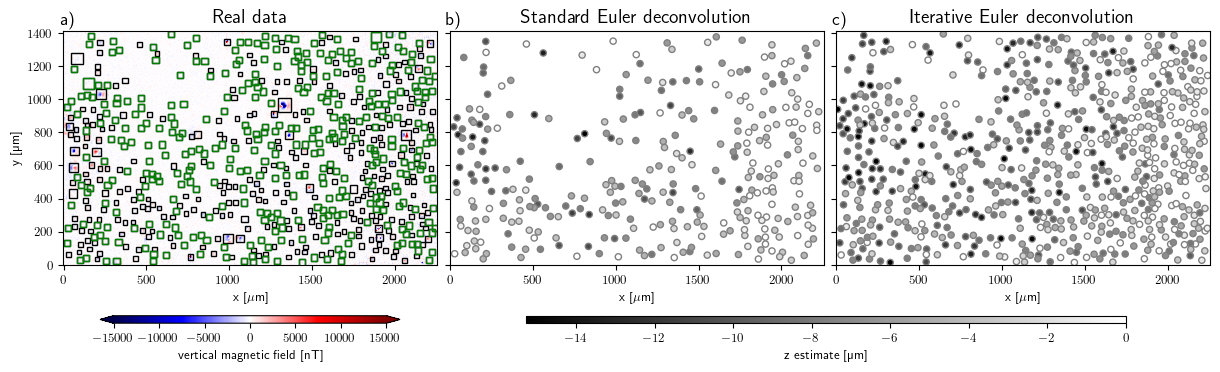

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

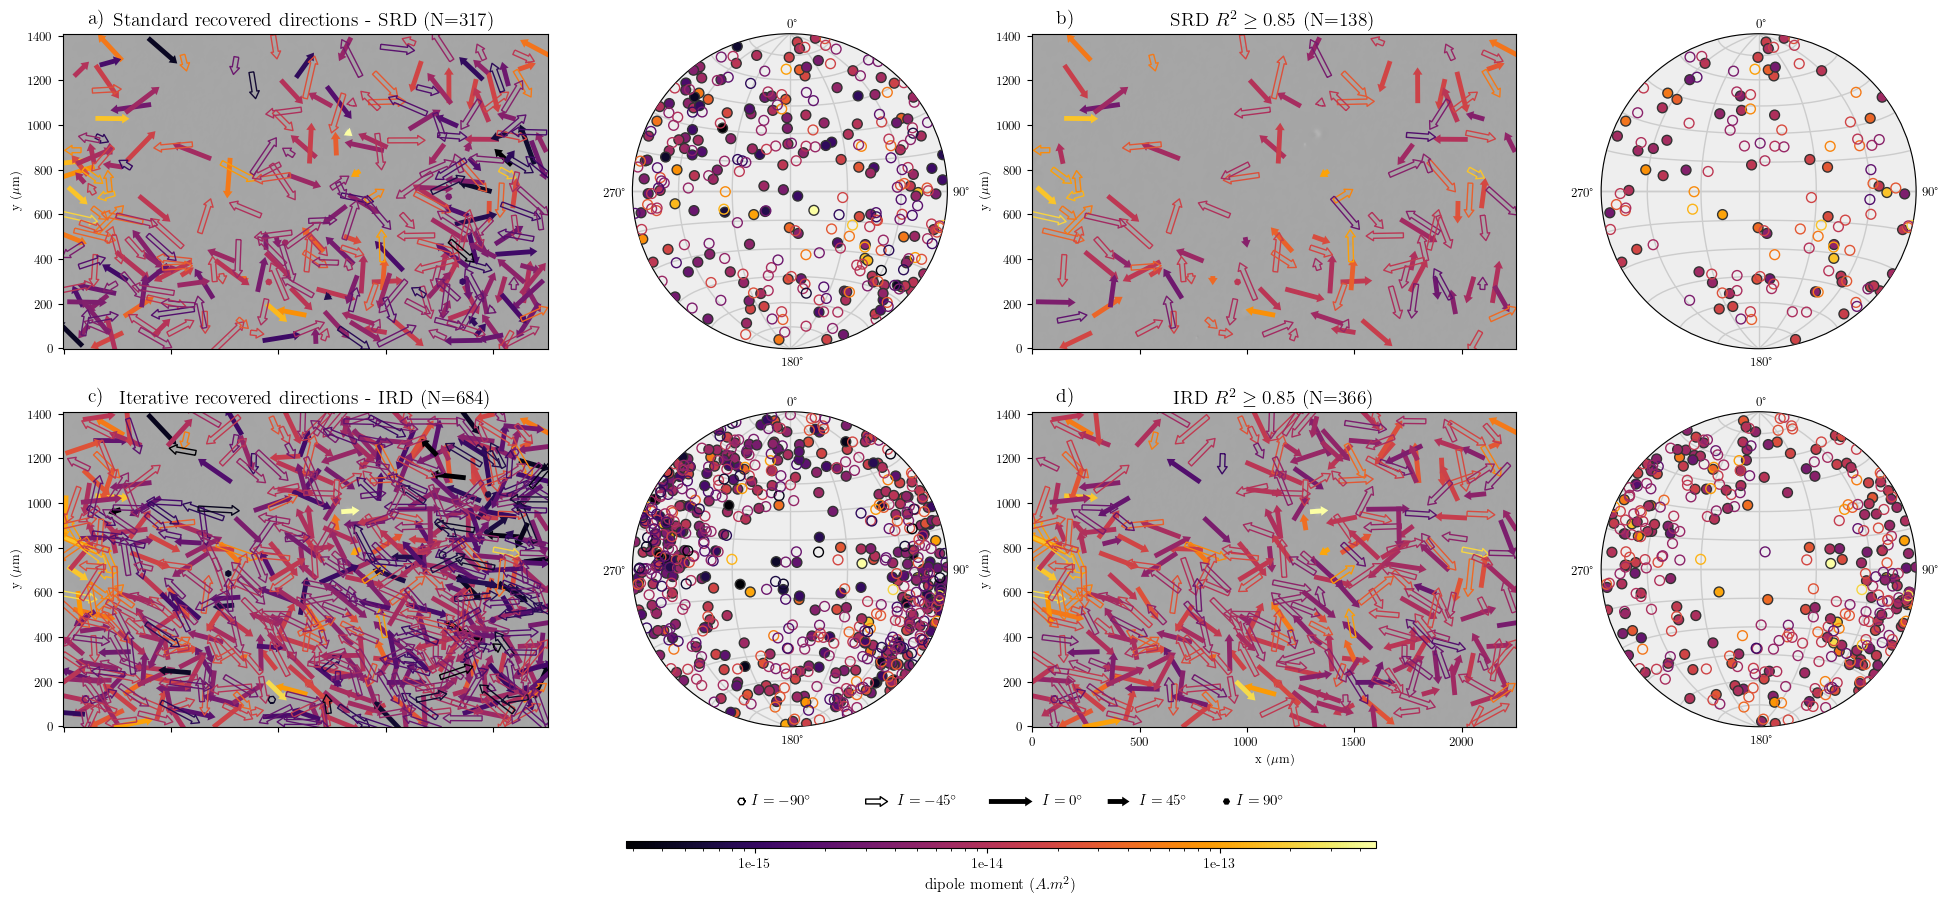

In [41]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    

    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

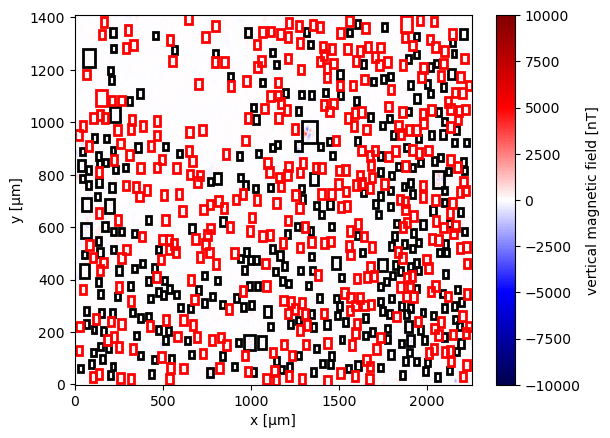

In [42]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [43]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.92730172,  0.94308567,  0.99413675,  0.86642667,  0.96958729,
        0.99484153,  0.95906299,  0.9865199 ,  0.97480446,  0.99907287,
        0.98103156,  0.91027282,  0.97061709,  0.87110079,  0.93691174,
        0.91921121,  0.93212371,  0.98212975,  0.96257858,  0.98644038,
        0.95072719,  0.98314412,  0.96223845,  0.9876409 ,  0.94869428,
        0.9898658 ,  0.96415881,  0.99607043,  0.98189572,  0.9890792 ,
        0.9915335 ,  0.99155894,  0.95501793,  0.98150356,  0.99419625,
        0.9809111 ,  0.98893984,  0.97904761,  0.97670648,  0.97823804,
        0.97482692, -0.08224696,  0.97156   ,  0.94137713,  0.7521024 ,
        0.97377857,  0.98942228,  0.96323579,  0.69691669,  0.99374943,
        0.68490742,  0.96507218,  0.95933708,  0.99038724,  0.94900076,
        0.97712846,  0.95533742,  0.86654009,  0.88628743,  0.97726412,
        0.94662801,  0.9553157 ,  0.97292847,  0.84445786,  0.94388882,
        0.89839727,  0.9069427 ,  0.97309989,  0.99336313,  0.97

# Show the observed and predicted data

In [44]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

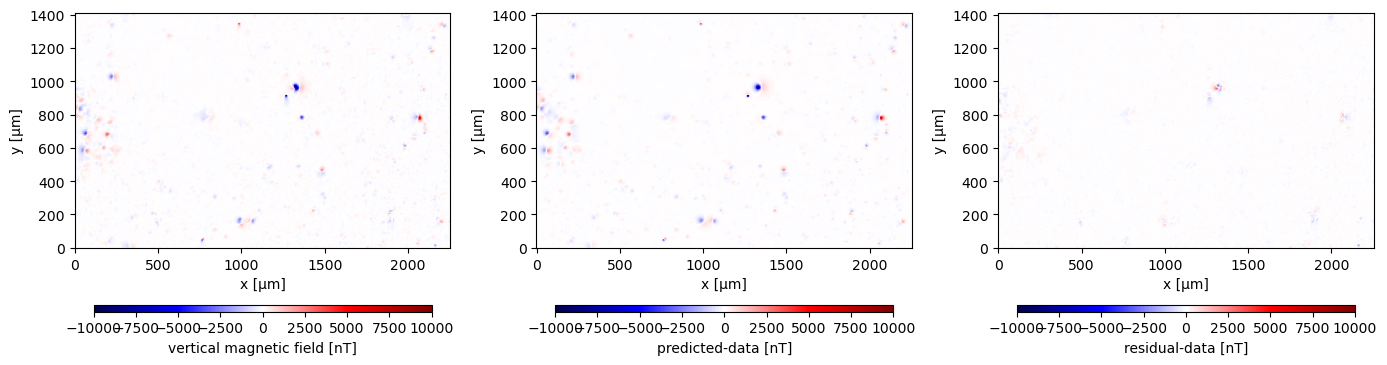

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9273017225041493


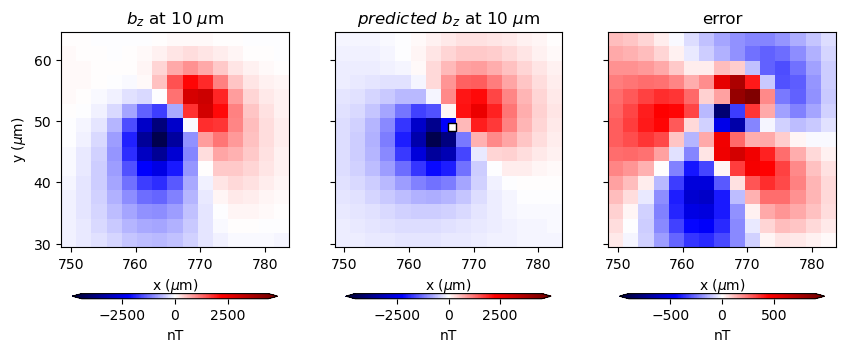

2
Individual source:   R2 = 0.9430856711713366


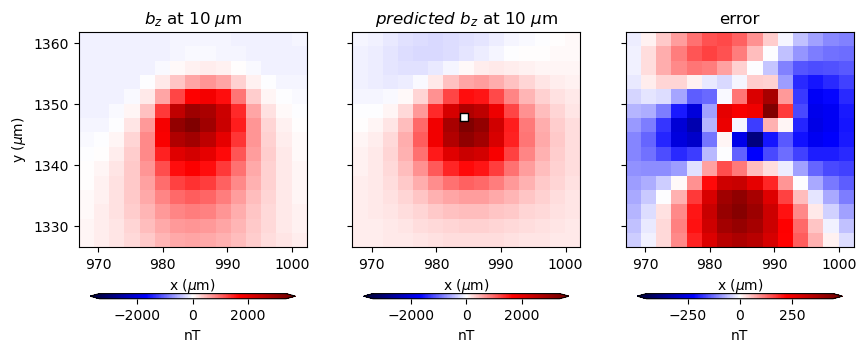

3
Individual source:   R2 = 0.9941367508948135


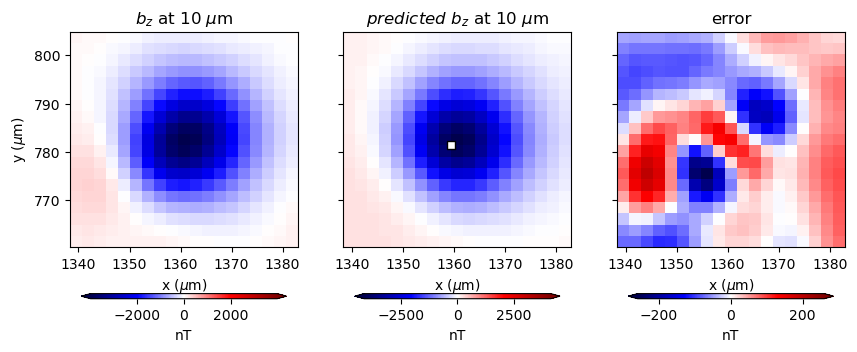

4
Individual source:   R2 = 0.8664266733172874


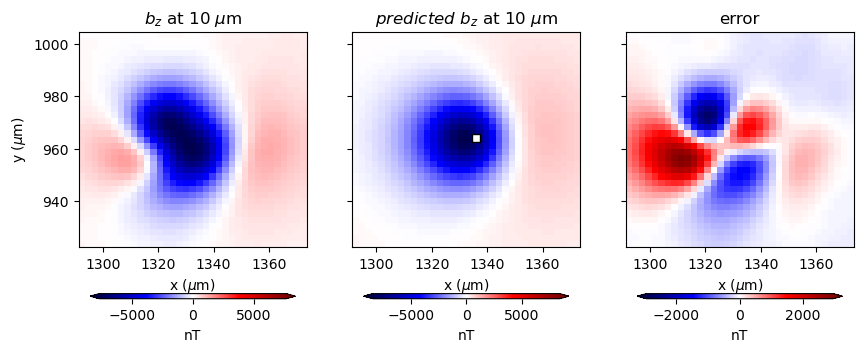

5
Individual source:   R2 = 0.9695872920060615


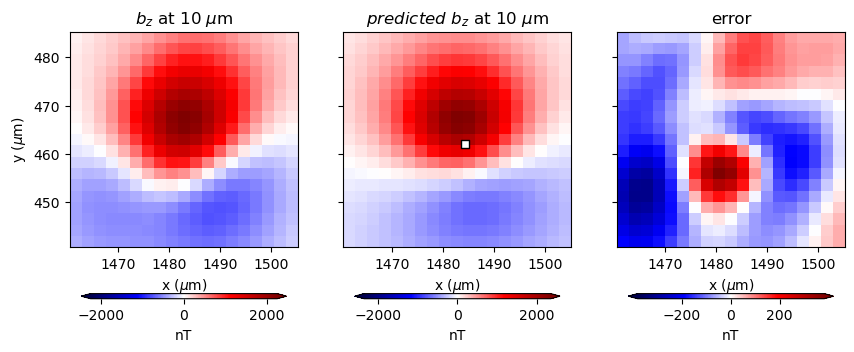

In [46]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [47]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [48]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)